In [1]:
%matplotlib inline

In [2]:
# 1) Wipe out all Python variables
%reset -f
# 2) Force Python’s garbage collector to run
import gc
gc.collect()

import multiprocessing as mp
mp.set_start_method('spawn', force=True)

import importlib
from libs import trades, plots, params, models
importlib.reload(trades)
importlib.reload(plots)
importlib.reload(params)
importlib.reload(models)

import math
import pandas as pd
from pandas import Timestamp
import numpy as np

import glob
import datetime as dt
from datetime import datetime

import optuna
from optuna.trial import TrialState
from optuna.importance import get_param_importances
from optuna.visualization.matplotlib import plot_optimization_history

import json
import matplotlib.pyplot as plt
from IPython.display import display, clear_output, update_display, HTML


from tqdm.auto import tqdm

pd.set_option('display.max_columns', None)

import os # Force fully single-threaded
os.environ["OMP_NUM_THREADS"]    = "1"
os.environ["MKL_NUM_THREADS"]    = "1"
os.environ["NUMEXPR_NUM_THREADS"]= "1"

[main] Found existing base CSV: dfs_training/GOOGL_base.csv


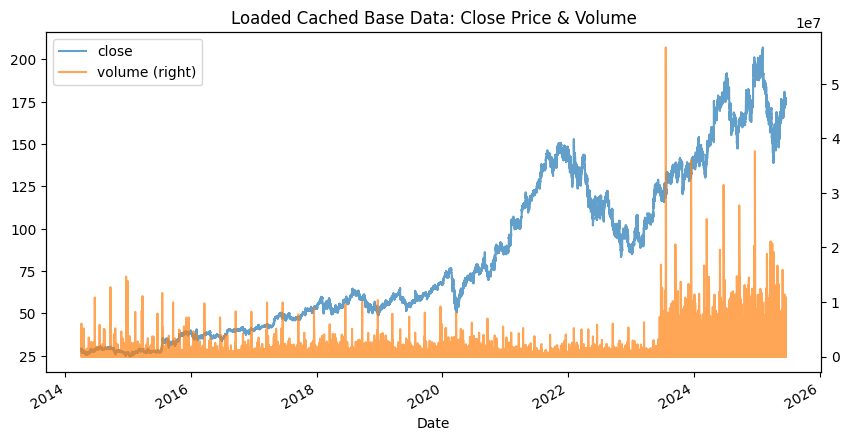

,open,high,low,close,volume,ask,bid
2014-04-03 08:30:00,28.650,28.6500,28.650,28.6500,2000.0,28.658595,28.641405
2014-04-03 08:31:00,28.650,28.6500,28.650,28.6500,2000.0,28.658595,28.641405
2014-04-03 08:32:00,28.650,28.6500,28.650,28.6500,2000.0,28.658595,28.641405
2014-04-03 08:33:00,28.650,28.6500,28.650,28.6500,2000.0,28.658595,28.641405
2014-04-03 08:34:00,28.650,28.6500,28.650,28.6500,2000.0,28.658595,28.641405
...,...,...,...,...,...,...,...
2025-06-18 20:56:00,173.375,173.6771,173.215,173.5650,621199.0,173.617100,173.512900
2025-06-18 20:57:00,173.565,173.5900,173.240,173.3800,624198.0,173.432000,173.328000
2025-06-18 20:58:00,173.390,173.4100,173.200,173.3100,454542.0,173.362000,173.258000
2025-06-18 20:59:00,173.315,173.4000,173.230,173.2800,1094746.0,173.332000,173.228000


In [3]:
ticker         = params.ticker
save_path      = params.save_path

results_folder = "optuna results"              
n_trials = 120
n_jobs = 1

base_csv = os.path.join(save_path, f"{ticker}_base.csv")

if os.path.exists(base_csv):
    # -----------------------------------------------------------------
    # 1) Cached file exists → load it, plot it, skip all processing.
    # -----------------------------------------------------------------
    print(f"[main] Found existing base CSV: {base_csv}")
    df = pd.read_csv(base_csv, index_col=0, parse_dates=True)
    plots.plot_close_volume(
        df,
        title="Loaded Cached Base Data: Close Price & Volume"
    )

else:
    # -----------------------------------------------------------------
    # 2) No cached file → do the full split‐adjust and then minute‐grid prep
    # -----------------------------------------------------------------
    print(f"[main] No base CSV found; running process_splits …")
    df_raw = trades.process_splits(
        folder                   = params.stocks_folder,
        ticker                   = ticker,
        bidasktoclose_spread     = params.bidasktoclose_spread
    )

    # Once‐only minute grid build and interpolation
    print(f"[main] Running prepare_interpolate_data …")
    df = trades.prepare_interpolate_data(
        df                    = df_raw,
        regular_start_shifted = params.regular_start_shifted,
        regular_start         = params.regular_start,
        regular_end           = params.regular_end
    )
    
    # Persist to base CSV and return
    df.to_csv(base_csv)
    print(f"[process_splits] Saved processed data to: {base_csv}")

# df is now guaranteed to be the split‐adjusted, minute‐aligned DataFrame
df


In [4]:
def optimization_function(
    df,
    look_back,
    min_prof_thr, 
    max_down_prop, 
    gain_tightening_factor, 
    merging_retracement_thr, 
    merging_time_gap_thr, 
    smooth_win_sig, 
    pre_entry_decay, 
    short_penalty,
    trailing_stop_thresh,
    buy_threshold
) -> float:
    """
    1) Compute median‐profit reference for this trial's thresholds.
    2) Run full backtest → one Strategy Return ($) per calendar day.
    3) Compute:
        - total_pnl       : sum of daily P&L across all trading days
        - avg_daily_pnl   : total_pnl divided by # of unique trading days
    4) Print both, return avg_daily_pnl to Optuna.
    """
    
    regular_start_pred = dt.time(*divmod(params.regular_start.hour * 60 + params.regular_start.minute - look_back, 60))
    regular_start_shifted = dt.time(*divmod(params.regular_start.hour * 60 + params.regular_start.minute - look_back*2, 60))

    # A) dynamic reference profit (median of all trade profits)
    ref_profit = trades.compute_global_ref_profit(
        df,
        min_prof_thr            = min_prof_thr,
        max_down_prop           = max_down_prop,
        gain_tightening_factor  = gain_tightening_factor,
        merging_retracement_thr = merging_retracement_thr,
        merging_time_gap_thr    = merging_time_gap_thr,
        regular_start_pred      = regular_start_pred,
        regular_end             = params.regular_end
    )

    # B) run backtest, collect one return per day
    simulation = trades.run_trading_pipeline(
        df                       = df,
        col_signal               = 'signal_smooth',
        col_action               = 'signal_action',
        ref_profit               = ref_profit,
        smooth_win_sig           = smooth_win_sig,
        pre_entry_decay          = pre_entry_decay,
        short_penalty            = short_penalty,
        trailing_stop_thresh     = trailing_stop_thresh,
        buy_threshold            = buy_threshold,
        regular_start_shifted    = regular_start_shifted
    )

    # C) extract daily P&L values
    daily_returns = [
        stats['Strategy Return ($)'] 
        for _, (_, _, stats) in simulation.items()
    ]
    total_pnl = float(np.sum(daily_returns))

    # D) compute average daily P&L (zero‐trade days count as $0)
    trading_days   = df.index.normalize().unique()
    num_trading_days = len(trading_days)
    avg_daily_pnl = total_pnl / num_trading_days if num_trading_days else 0.0

    # E) report & cleanup
    print(f"→ Total P&L across {num_trading_days} days: ${total_pnl:.2f}")
    print(f"→ Average daily P&L             : ${avg_daily_pnl:.4f}\n")

    del simulation, daily_returns
    gc.collect()

    return avg_daily_pnl


In [5]:
def objective(trial):
    # 1) sample everything into a dict
    hyperpars = {
        "look_back"               : trial.suggest_categorical("look_back", [30,60,90,120,150,180]),
        "min_prof_thr"            : trial.suggest_float("min_prof_thr", 0.1, 1),
        "max_down_prop"           : trial.suggest_float("max_down_prop", 0.1, 0.9),
        "gain_tightening_factor"  : trial.suggest_float("gain_tightening_factor", 0.1, 1),
        "merging_retracement_thr" : trial.suggest_float("merging_retracement_thr", 0.1, 1),
        "merging_time_gap_thr"    : trial.suggest_float("merging_time_gap_thr", 0.1, 1),
        "smooth_win_sig"          : trial.suggest_categorical("smooth_win_sig", [15,20,30,45,60,90,120,180,240]),
        "pre_entry_decay"         : trial.suggest_float("pre_entry_decay", 0.01, 0.5),
        "short_penalty"           : trial.suggest_float("short_penalty", 0.05, 0.75),
        "trailing_stop_thresh"    : trial.suggest_float("trailing_stop_thresh", 0.05, 0.75),
        "buy_threshold"           : trial.suggest_float("buy_threshold", 0.05, 0.75),
    }

    # 2) Log the values for this trial
    print(f"\n▶ Trial {trial.number} Hyperparameters:")
    for name, val in hyperpars.items():
        print(f"    {name:30s} = {val}")
    print()

    # 3) Run the backtest & optimization function
    #    This will print Total P&L and Average Daily P&L,
    #    and return `avg_daily_pnl` for Optuna to maximize.
    avg_daily_pnl = optimization_function(df=df, **hyperpars)

    return avg_daily_pnl


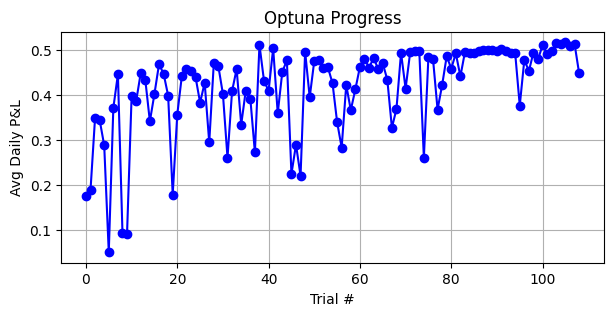

In [6]:

# small lists that hold only one int & float per trial
trial_x = []
trial_y = []

# build the blank figure once (same as before)
fig, ax = plt.subplots(figsize=(7, 3))
line, = ax.plot([], [], "bo-")
ax.set(xlabel="Trial #", ylabel="Avg Daily P&L", title="Optuna Progress")
ax.grid(True)
handle = display(fig, display_id=True)
plt.close(fig)

def lightweight_plot_callback(study, trial):
    # Append just the new trial’s number & objective
    trial_x.append(trial.number)
    trial_y.append(trial.value)

    # Update the line data
    line.set_data(trial_x, trial_y)
    ax.relim()
    ax.autoscale_view()
    handle.update(fig)


In [ ]:
# === Create and Run the Study ===
pruner = optuna.pruners.MedianPruner(n_startup_trials=6, n_warmup_steps=12)

study = optuna.create_study(
    storage="sqlite:///optuna_study.db",    # Point it at an SQLite file so it writes out each result immediately instead of buffering in RAM
    load_if_exists=True,
    direction="maximize",
    pruner=pruner,
)

def cleanup_cb(study, trial):
    import gc
    gc.collect()

study.optimize(
    objective,
    n_trials=n_trials,
    n_jobs=n_jobs,       # run trials concurrently
    callbacks=[cleanup_cb, lightweight_plot_callback],
    gc_after_trial=True,
)

fig, ax = plt.subplots(figsize=(8, 4))
plot_optimization_history(study, ax)
ax.set_title("Optuna Optimization History")
plt.show()

# === Print Final Results ===
print("Best Parameters:", study.best_params)
print("Best Average Improvement:", study.best_value)

# === Compute & Print Hyperparameter Importances ===
importances = get_param_importances(study)
print("\nHyperparameter importances (higher ⇒ more impact):")
for name, score in sorted(importances.items(), key=lambda x: x[1], reverse=True):
    print(f"  {name:20s} : {score:.3f}")

# ------------------------------------------------------------------
# Build a dynamic file-name .json
# ------------------------------------------------------------------
# 1) Build your session‐only DataFrame once
session_df = df.between_time(params.regular_start,
                             params.regular_end)

# 2) Derive the trading‐day boundaries
first_day = session_df.index.normalize().min()
last_day  = session_df.index.normalize().max()

# 3) Format your file name
start_date = first_day.strftime("%Y%m%d")
end_date   = last_day.strftime("%Y%m%d")
file_name  = f"{ticker}_{start_date}-{end_date}_optuna_signal_pars.json"
file_path  = os.path.join(results_folder, file_name)


# ------------------------------------------------------------------
# Dump study results (including importances)
# ------------------------------------------------------------------
with open(file_path, "w") as f:
    json.dump(
        {
            "best_params":   study.best_params,
            "best_value":    study.best_value,
            "importances":   importances,
            "trials": [
                {
                    "number": t.number,
                    "value":  t.value,
                    "params": t.params,
                    "state":  t.state.name
                }
                for t in study.trials
            ],
        },
        f,
        indent=4,
    )

print(f"\nOptuna results (and importances) saved to: {file_path}")


[I 2025-07-28 13:58:51,165] A new study created in RDB with name: no-name-d34c7c1e-cde7-4e3d-94ae-0d6b25fb54c9



▶ Trial 0 Hyperparameters:
    look_back                      = 120
    min_prof_thr                   = 0.559961564127585
    max_down_prop                  = 0.6567780926628884
    gain_tightening_factor         = 0.8379753783346929
    merging_retracement_thr        = 0.7937634615520912
    merging_time_gap_thr           = 0.37788550723868053
    smooth_win_sig                 = 90
    pre_entry_decay                = 0.4105482313598284
    short_penalty                  = 0.7288150555328673
    trailing_stop_thresh           = 0.6647345797026786
    buy_threshold                  = 0.3421364056355879

Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …
→ Total P&L across 2820 days: $491.92
→ Average daily P&L             : $0.1744



[I 2025-07-28 14:00:28,287] Trial 0 finished with value: 0.17444007092198582 and parameters: {'look_back': 120, 'min_prof_thr': 0.559961564127585, 'max_down_prop': 0.6567780926628884, 'gain_tightening_factor': 0.8379753783346929, 'merging_retracement_thr': 0.7937634615520912, 'merging_time_gap_thr': 0.37788550723868053, 'smooth_win_sig': 90, 'pre_entry_decay': 0.4105482313598284, 'short_penalty': 0.7288150555328673, 'trailing_stop_thresh': 0.6647345797026786, 'buy_threshold': 0.3421364056355879}. Best is trial 0 with value: 0.17444007092198582.



▶ Trial 1 Hyperparameters:
    look_back                      = 90
    min_prof_thr                   = 0.34320022707912223
    max_down_prop                  = 0.40601838735826457
    gain_tightening_factor         = 0.5913103796707795
    merging_retracement_thr        = 0.45726430937305973
    merging_time_gap_thr           = 0.2967679187912477
    smooth_win_sig                 = 240
    pre_entry_decay                = 0.2403550204925198
    short_penalty                  = 0.2488444819932939
    trailing_stop_thresh           = 0.37602146907517114
    buy_threshold                  = 0.5773121252801243

Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …
→ Total P&L across 2820 days: $530.78
→ Average daily P&L             : $0.1882



[I 2025-07-28 14:02:08,402] Trial 1 finished with value: 0.18822163120567376 and parameters: {'look_back': 90, 'min_prof_thr': 0.34320022707912223, 'max_down_prop': 0.40601838735826457, 'gain_tightening_factor': 0.5913103796707795, 'merging_retracement_thr': 0.45726430937305973, 'merging_time_gap_thr': 0.2967679187912477, 'smooth_win_sig': 240, 'pre_entry_decay': 0.2403550204925198, 'short_penalty': 0.2488444819932939, 'trailing_stop_thresh': 0.37602146907517114, 'buy_threshold': 0.5773121252801243}. Best is trial 1 with value: 0.18822163120567376.



▶ Trial 2 Hyperparameters:
    look_back                      = 120
    min_prof_thr                   = 0.9348640994965743
    max_down_prop                  = 0.2280041091608271
    gain_tightening_factor         = 0.37714152944817003
    merging_retracement_thr        = 0.10921223693437443
    merging_time_gap_thr           = 0.26013538082000615
    smooth_win_sig                 = 20
    pre_entry_decay                = 0.32068520592754196
    short_penalty                  = 0.11357287431703786
    trailing_stop_thresh           = 0.629237762652083
    buy_threshold                  = 0.2949363862155131

Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …
→ Total P&L across 2820 days: $986.50
→ Average daily P&L             : $0.3498



[I 2025-07-28 14:04:53,787] Trial 2 finished with value: 0.3498212765957447 and parameters: {'look_back': 120, 'min_prof_thr': 0.9348640994965743, 'max_down_prop': 0.2280041091608271, 'gain_tightening_factor': 0.37714152944817003, 'merging_retracement_thr': 0.10921223693437443, 'merging_time_gap_thr': 0.26013538082000615, 'smooth_win_sig': 20, 'pre_entry_decay': 0.32068520592754196, 'short_penalty': 0.11357287431703786, 'trailing_stop_thresh': 0.629237762652083, 'buy_threshold': 0.2949363862155131}. Best is trial 2 with value: 0.3498212765957447.



▶ Trial 3 Hyperparameters:
    look_back                      = 180
    min_prof_thr                   = 0.7239331989637428
    max_down_prop                  = 0.6416099845976019
    gain_tightening_factor         = 0.12084829620786992
    merging_retracement_thr        = 0.8576421131218015
    merging_time_gap_thr           = 0.32178449416972454
    smooth_win_sig                 = 90
    pre_entry_decay                = 0.16307301758388149
    short_penalty                  = 0.6196509874820769
    trailing_stop_thresh           = 0.17003500913530753
    buy_threshold                  = 0.10033572127474959

Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …
→ Total P&L across 2820 days: $972.24
→ Average daily P&L             : $0.3448



[I 2025-07-28 14:08:12,769] Trial 3 finished with value: 0.34476666666666667 and parameters: {'look_back': 180, 'min_prof_thr': 0.7239331989637428, 'max_down_prop': 0.6416099845976019, 'gain_tightening_factor': 0.12084829620786992, 'merging_retracement_thr': 0.8576421131218015, 'merging_time_gap_thr': 0.32178449416972454, 'smooth_win_sig': 90, 'pre_entry_decay': 0.16307301758388149, 'short_penalty': 0.6196509874820769, 'trailing_stop_thresh': 0.17003500913530753, 'buy_threshold': 0.10033572127474959}. Best is trial 2 with value: 0.3498212765957447.



▶ Trial 4 Hyperparameters:
    look_back                      = 90
    min_prof_thr                   = 0.24924130203604317
    max_down_prop                  = 0.4106260113303847
    gain_tightening_factor         = 0.47893892604025257
    merging_retracement_thr        = 0.3198954789040964
    merging_time_gap_thr           = 0.5616189740849714
    smooth_win_sig                 = 240
    pre_entry_decay                = 0.37116626724101787
    short_penalty                  = 0.2648420572270844
    trailing_stop_thresh           = 0.36973440956586107
    buy_threshold                  = 0.4131880292782208

Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …
→ Total P&L across 2820 days: $812.58
→ Average daily P&L             : $0.2882



[I 2025-07-28 14:10:59,033] Trial 4 finished with value: 0.28815070921985814 and parameters: {'look_back': 90, 'min_prof_thr': 0.24924130203604317, 'max_down_prop': 0.4106260113303847, 'gain_tightening_factor': 0.47893892604025257, 'merging_retracement_thr': 0.3198954789040964, 'merging_time_gap_thr': 0.5616189740849714, 'smooth_win_sig': 240, 'pre_entry_decay': 0.37116626724101787, 'short_penalty': 0.2648420572270844, 'trailing_stop_thresh': 0.36973440956586107, 'buy_threshold': 0.4131880292782208}. Best is trial 2 with value: 0.3498212765957447.



▶ Trial 5 Hyperparameters:
    look_back                      = 60
    min_prof_thr                   = 0.9388038515414222
    max_down_prop                  = 0.35676254701989607
    gain_tightening_factor         = 0.22609987993407477
    merging_retracement_thr        = 0.2954113464548491
    merging_time_gap_thr           = 0.13890613584000674
    smooth_win_sig                 = 180
    pre_entry_decay                = 0.050729414810913476
    short_penalty                  = 0.3360639816849358
    trailing_stop_thresh           = 0.23705640182561705
    buy_threshold                  = 0.7131263704107164

Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …
→ Total P&L across 2820 days: $139.74
→ Average daily P&L             : $0.0496



[I 2025-07-28 14:13:32,218] Trial 5 finished with value: 0.049552482269503546 and parameters: {'look_back': 60, 'min_prof_thr': 0.9388038515414222, 'max_down_prop': 0.35676254701989607, 'gain_tightening_factor': 0.22609987993407477, 'merging_retracement_thr': 0.2954113464548491, 'merging_time_gap_thr': 0.13890613584000674, 'smooth_win_sig': 180, 'pre_entry_decay': 0.050729414810913476, 'short_penalty': 0.3360639816849358, 'trailing_stop_thresh': 0.23705640182561705, 'buy_threshold': 0.7131263704107164}. Best is trial 2 with value: 0.3498212765957447.



▶ Trial 6 Hyperparameters:
    look_back                      = 90
    min_prof_thr                   = 0.2264201456575382
    max_down_prop                  = 0.48746113131691504
    gain_tightening_factor         = 0.2374893004979335
    merging_retracement_thr        = 0.1398737951466039
    merging_time_gap_thr           = 0.9449627923183412
    smooth_win_sig                 = 90
    pre_entry_decay                = 0.36393694171680985
    short_penalty                  = 0.5876528577353465
    trailing_stop_thresh           = 0.06865189730247492
    buy_threshold                  = 0.22286696500032788

Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …
→ Total P&L across 2820 days: $1047.75
→ Average daily P&L             : $0.3715



[I 2025-07-28 14:16:13,334] Trial 6 finished with value: 0.3715439716312057 and parameters: {'look_back': 90, 'min_prof_thr': 0.2264201456575382, 'max_down_prop': 0.48746113131691504, 'gain_tightening_factor': 0.2374893004979335, 'merging_retracement_thr': 0.1398737951466039, 'merging_time_gap_thr': 0.9449627923183412, 'smooth_win_sig': 90, 'pre_entry_decay': 0.36393694171680985, 'short_penalty': 0.5876528577353465, 'trailing_stop_thresh': 0.06865189730247492, 'buy_threshold': 0.22286696500032788}. Best is trial 6 with value: 0.3715439716312057.



▶ Trial 7 Hyperparameters:
    look_back                      = 60
    min_prof_thr                   = 0.5290276284208683
    max_down_prop                  = 0.47998465454801065
    gain_tightening_factor         = 0.8713993398766111
    merging_retracement_thr        = 0.9670654433814294
    merging_time_gap_thr           = 0.329016781721597
    smooth_win_sig                 = 15
    pre_entry_decay                = 0.38847151083273584
    short_penalty                  = 0.3758478294843927
    trailing_stop_thresh           = 0.3259817213501956
    buy_threshold                  = 0.17572263124813042

Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …
→ Total P&L across 2820 days: $1259.01
→ Average daily P&L             : $0.4465



[I 2025-07-28 14:17:45,025] Trial 7 finished with value: 0.4464578014184397 and parameters: {'look_back': 60, 'min_prof_thr': 0.5290276284208683, 'max_down_prop': 0.47998465454801065, 'gain_tightening_factor': 0.8713993398766111, 'merging_retracement_thr': 0.9670654433814294, 'merging_time_gap_thr': 0.329016781721597, 'smooth_win_sig': 15, 'pre_entry_decay': 0.38847151083273584, 'short_penalty': 0.3758478294843927, 'trailing_stop_thresh': 0.3259817213501956, 'buy_threshold': 0.17572263124813042}. Best is trial 7 with value: 0.4464578014184397.



▶ Trial 8 Hyperparameters:
    look_back                      = 150
    min_prof_thr                   = 0.5127929706534476
    max_down_prop                  = 0.19210450413039074
    gain_tightening_factor         = 0.8739975796345432
    merging_retracement_thr        = 0.22993535286722216
    merging_time_gap_thr           = 0.6221503096435811
    smooth_win_sig                 = 60
    pre_entry_decay                = 0.4505646638760044
    short_penalty                  = 0.588032710781991
    trailing_stop_thresh           = 0.10674552811135576
    buy_threshold                  = 0.5826247693955162

Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …
→ Total P&L across 2820 days: $263.70
→ Average daily P&L             : $0.0935



[I 2025-07-28 14:19:30,202] Trial 8 finished with value: 0.09351028368794327 and parameters: {'look_back': 150, 'min_prof_thr': 0.5127929706534476, 'max_down_prop': 0.19210450413039074, 'gain_tightening_factor': 0.8739975796345432, 'merging_retracement_thr': 0.22993535286722216, 'merging_time_gap_thr': 0.6221503096435811, 'smooth_win_sig': 60, 'pre_entry_decay': 0.4505646638760044, 'short_penalty': 0.588032710781991, 'trailing_stop_thresh': 0.10674552811135576, 'buy_threshold': 0.5826247693955162}. Best is trial 7 with value: 0.4464578014184397.



▶ Trial 9 Hyperparameters:
    look_back                      = 120
    min_prof_thr                   = 0.9719017647861145
    max_down_prop                  = 0.12284987031264115
    gain_tightening_factor         = 0.6845126447963306
    merging_retracement_thr        = 0.72416246866648
    merging_time_gap_thr           = 0.2971983369515749
    smooth_win_sig                 = 60
    pre_entry_decay                = 0.3164914566708285
    short_penalty                  = 0.7475956306122133
    trailing_stop_thresh           = 0.49231357139731463
    buy_threshold                  = 0.4360764224706935

Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …
→ Total P&L across 2820 days: $254.88
→ Average daily P&L             : $0.0904



[I 2025-07-28 14:21:45,220] Trial 9 finished with value: 0.09038297872340426 and parameters: {'look_back': 120, 'min_prof_thr': 0.9719017647861145, 'max_down_prop': 0.12284987031264115, 'gain_tightening_factor': 0.6845126447963306, 'merging_retracement_thr': 0.72416246866648, 'merging_time_gap_thr': 0.2971983369515749, 'smooth_win_sig': 60, 'pre_entry_decay': 0.3164914566708285, 'short_penalty': 0.7475956306122133, 'trailing_stop_thresh': 0.49231357139731463, 'buy_threshold': 0.4360764224706935}. Best is trial 7 with value: 0.4464578014184397.



▶ Trial 10 Hyperparameters:
    look_back                      = 60
    min_prof_thr                   = 0.6773625225849316
    max_down_prop                  = 0.8318161691836057
    gain_tightening_factor         = 0.9992351044294281
    merging_retracement_thr        = 0.987923018499933
    merging_time_gap_thr           = 0.7480589938060834
    smooth_win_sig                 = 15
    pre_entry_decay                = 0.204795377389647
    short_penalty                  = 0.4456365937108152
    trailing_stop_thresh           = 0.49291786506254864
    buy_threshold                  = 0.05366996419409263

Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …
→ Total P&L across 2820 days: $1120.79
→ Average daily P&L             : $0.3974



[I 2025-07-28 14:24:15,143] Trial 10 finished with value: 0.39744468085106377 and parameters: {'look_back': 60, 'min_prof_thr': 0.6773625225849316, 'max_down_prop': 0.8318161691836057, 'gain_tightening_factor': 0.9992351044294281, 'merging_retracement_thr': 0.987923018499933, 'merging_time_gap_thr': 0.7480589938060834, 'smooth_win_sig': 15, 'pre_entry_decay': 0.204795377389647, 'short_penalty': 0.4456365937108152, 'trailing_stop_thresh': 0.49291786506254864, 'buy_threshold': 0.05366996419409263}. Best is trial 7 with value: 0.4464578014184397.



▶ Trial 11 Hyperparameters:
    look_back                      = 60
    min_prof_thr                   = 0.682280016532347
    max_down_prop                  = 0.8990592525720771
    gain_tightening_factor         = 0.9865078386003175
    merging_retracement_thr        = 0.9993782658170917
    merging_time_gap_thr           = 0.7711177349104911
    smooth_win_sig                 = 15
    pre_entry_decay                = 0.18136806016467816
    short_penalty                  = 0.4287483821683265
    trailing_stop_thresh           = 0.5211970798584212
    buy_threshold                  = 0.05640885686982553

Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …
→ Total P&L across 2820 days: $1090.80
→ Average daily P&L             : $0.3868



[I 2025-07-28 14:26:49,442] Trial 11 finished with value: 0.3868078014184396 and parameters: {'look_back': 60, 'min_prof_thr': 0.682280016532347, 'max_down_prop': 0.8990592525720771, 'gain_tightening_factor': 0.9865078386003175, 'merging_retracement_thr': 0.9993782658170917, 'merging_time_gap_thr': 0.7711177349104911, 'smooth_win_sig': 15, 'pre_entry_decay': 0.18136806016467816, 'short_penalty': 0.4287483821683265, 'trailing_stop_thresh': 0.5211970798584212, 'buy_threshold': 0.05640885686982553}. Best is trial 7 with value: 0.4464578014184397.



▶ Trial 12 Hyperparameters:
    look_back                      = 30
    min_prof_thr                   = 0.46525272112919785
    max_down_prop                  = 0.7994592102595148
    gain_tightening_factor         = 0.9827017185602311
    merging_retracement_thr        = 0.9781044717574305
    merging_time_gap_thr           = 0.8489702080450718
    smooth_win_sig                 = 15
    pre_entry_decay                = 0.4991673111001736
    short_penalty                  = 0.45135807753888757
    trailing_stop_thresh           = 0.2670895587374898
    buy_threshold                  = 0.17244967842416697

Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …
→ Total P&L across 2820 days: $1267.15
→ Average daily P&L             : $0.4493



[I 2025-07-28 14:29:16,173] Trial 12 finished with value: 0.4493450354609929 and parameters: {'look_back': 30, 'min_prof_thr': 0.46525272112919785, 'max_down_prop': 0.7994592102595148, 'gain_tightening_factor': 0.9827017185602311, 'merging_retracement_thr': 0.9781044717574305, 'merging_time_gap_thr': 0.8489702080450718, 'smooth_win_sig': 15, 'pre_entry_decay': 0.4991673111001736, 'short_penalty': 0.45135807753888757, 'trailing_stop_thresh': 0.2670895587374898, 'buy_threshold': 0.17244967842416697}. Best is trial 12 with value: 0.4493450354609929.



▶ Trial 13 Hyperparameters:
    look_back                      = 30
    min_prof_thr                   = 0.42081133760780187
    max_down_prop                  = 0.6586144627427657
    gain_tightening_factor         = 0.7699794793014234
    merging_retracement_thr        = 0.6943120228785975
    merging_time_gap_thr           = 0.9629719381811677
    smooth_win_sig                 = 15
    pre_entry_decay                = 0.4956713327157002
    short_penalty                  = 0.4967688797523864
    trailing_stop_thresh           = 0.2617824849731045
    buy_threshold                  = 0.19340374649077213

Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …
→ Total P&L across 2820 days: $1224.11
→ Average daily P&L             : $0.4341



[I 2025-07-28 14:31:37,264] Trial 13 finished with value: 0.4340826241134751 and parameters: {'look_back': 30, 'min_prof_thr': 0.42081133760780187, 'max_down_prop': 0.6586144627427657, 'gain_tightening_factor': 0.7699794793014234, 'merging_retracement_thr': 0.6943120228785975, 'merging_time_gap_thr': 0.9629719381811677, 'smooth_win_sig': 15, 'pre_entry_decay': 0.4956713327157002, 'short_penalty': 0.4967688797523864, 'trailing_stop_thresh': 0.2617824849731045, 'buy_threshold': 0.19340374649077213}. Best is trial 12 with value: 0.4493450354609929.



▶ Trial 14 Hyperparameters:
    look_back                      = 30
    min_prof_thr                   = 0.5056971654410598
    max_down_prop                  = 0.7678201813220723
    gain_tightening_factor         = 0.888105519635082
    merging_retracement_thr        = 0.5696468131166925
    merging_time_gap_thr           = 0.4456337276629747
    smooth_win_sig                 = 120
    pre_entry_decay                = 0.4805253988040019
    short_penalty                  = 0.32772257057220444
    trailing_stop_thresh           = 0.2687909369576661
    buy_threshold                  = 0.18911985344300541

Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …
→ Total P&L across 2820 days: $963.39
→ Average daily P&L             : $0.3416



[I 2025-07-28 14:33:57,094] Trial 14 finished with value: 0.3416269503546099 and parameters: {'look_back': 30, 'min_prof_thr': 0.5056971654410598, 'max_down_prop': 0.7678201813220723, 'gain_tightening_factor': 0.888105519635082, 'merging_retracement_thr': 0.5696468131166925, 'merging_time_gap_thr': 0.4456337276629747, 'smooth_win_sig': 120, 'pre_entry_decay': 0.4805253988040019, 'short_penalty': 0.32772257057220444, 'trailing_stop_thresh': 0.2687909369576661, 'buy_threshold': 0.18911985344300541}. Best is trial 12 with value: 0.4493450354609929.



▶ Trial 15 Hyperparameters:
    look_back                      = 30
    min_prof_thr                   = 0.38229394834604047
    max_down_prop                  = 0.5397592620096288
    gain_tightening_factor         = 0.6891742900821017
    merging_retracement_thr        = 0.8729877788364779
    merging_time_gap_thr           = 0.7376275460031511
    smooth_win_sig                 = 45
    pre_entry_decay                = 0.41890644352516354
    short_penalty                  = 0.12038378352309398
    trailing_stop_thresh           = 0.3178910558369941
    buy_threshold                  = 0.269554406652625

Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …
→ Total P&L across 2820 days: $1135.39
→ Average daily P&L             : $0.4026



[I 2025-07-28 14:36:20,570] Trial 15 finished with value: 0.4026205673758866 and parameters: {'look_back': 30, 'min_prof_thr': 0.38229394834604047, 'max_down_prop': 0.5397592620096288, 'gain_tightening_factor': 0.6891742900821017, 'merging_retracement_thr': 0.8729877788364779, 'merging_time_gap_thr': 0.7376275460031511, 'smooth_win_sig': 45, 'pre_entry_decay': 0.41890644352516354, 'short_penalty': 0.12038378352309398, 'trailing_stop_thresh': 0.3178910558369941, 'buy_threshold': 0.269554406652625}. Best is trial 12 with value: 0.4493450354609929.



▶ Trial 16 Hyperparameters:
    look_back                      = 180
    min_prof_thr                   = 0.10960540807714769
    max_down_prop                  = 0.5477863728390615
    gain_tightening_factor         = 0.7581440626233016
    merging_retracement_thr        = 0.9082377297101107
    merging_time_gap_thr           = 0.11531743511346704
    smooth_win_sig                 = 30
    pre_entry_decay                = 0.2963900223730114
    short_penalty                  = 0.5138229855653346
    trailing_stop_thresh           = 0.17932785433068843
    buy_threshold                  = 0.15079982782326126

Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …
→ Total P&L across 2820 days: $1322.04
→ Average daily P&L             : $0.4688



[I 2025-07-28 14:39:40,808] Trial 16 finished with value: 0.4688099290780142 and parameters: {'look_back': 180, 'min_prof_thr': 0.10960540807714769, 'max_down_prop': 0.5477863728390615, 'gain_tightening_factor': 0.7581440626233016, 'merging_retracement_thr': 0.9082377297101107, 'merging_time_gap_thr': 0.11531743511346704, 'smooth_win_sig': 30, 'pre_entry_decay': 0.2963900223730114, 'short_penalty': 0.5138229855653346, 'trailing_stop_thresh': 0.17932785433068843, 'buy_threshold': 0.15079982782326126}. Best is trial 16 with value: 0.4688099290780142.



▶ Trial 17 Hyperparameters:
    look_back                      = 180
    min_prof_thr                   = 0.14048856889036587
    max_down_prop                  = 0.746122729079609
    gain_tightening_factor         = 0.7404794181391735
    merging_retracement_thr        = 0.5941988721738629
    merging_time_gap_thr           = 0.12116353927870152
    smooth_win_sig                 = 30
    pre_entry_decay                = 0.09619799009843011
    short_penalty                  = 0.5086350453444677
    trailing_stop_thresh           = 0.17324596895404257
    buy_threshold                  = 0.1395915998631984

Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …
→ Total P&L across 2820 days: $1264.15
→ Average daily P&L             : $0.4483



[I 2025-07-28 14:43:02,084] Trial 17 finished with value: 0.4482801418439717 and parameters: {'look_back': 180, 'min_prof_thr': 0.14048856889036587, 'max_down_prop': 0.746122729079609, 'gain_tightening_factor': 0.7404794181391735, 'merging_retracement_thr': 0.5941988721738629, 'merging_time_gap_thr': 0.12116353927870152, 'smooth_win_sig': 30, 'pre_entry_decay': 0.09619799009843011, 'short_penalty': 0.5086350453444677, 'trailing_stop_thresh': 0.17324596895404257, 'buy_threshold': 0.1395915998631984}. Best is trial 16 with value: 0.4688099290780142.



▶ Trial 18 Hyperparameters:
    look_back                      = 180
    min_prof_thr                   = 0.12818422904293508
    max_down_prop                  = 0.5779704383005443
    gain_tightening_factor         = 0.5975759716237661
    merging_retracement_thr        = 0.8951704759323249
    merging_time_gap_thr           = 0.822250615063773
    smooth_win_sig                 = 30
    pre_entry_decay                = 0.2941289361294326
    short_penalty                  = 0.6509507144997174
    trailing_stop_thresh           = 0.15867423680986897
    buy_threshold                  = 0.35310923472931177

Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …
→ Total P&L across 2820 days: $1125.17
→ Average daily P&L             : $0.3990



[I 2025-07-28 14:45:27,441] Trial 18 finished with value: 0.39899645390070926 and parameters: {'look_back': 180, 'min_prof_thr': 0.12818422904293508, 'max_down_prop': 0.5779704383005443, 'gain_tightening_factor': 0.5975759716237661, 'merging_retracement_thr': 0.8951704759323249, 'merging_time_gap_thr': 0.822250615063773, 'smooth_win_sig': 30, 'pre_entry_decay': 0.2941289361294326, 'short_penalty': 0.6509507144997174, 'trailing_stop_thresh': 0.15867423680986897, 'buy_threshold': 0.35310923472931177}. Best is trial 16 with value: 0.4688099290780142.



▶ Trial 19 Hyperparameters:
    look_back                      = 150
    min_prof_thr                   = 0.8154670036064962
    max_down_prop                  = 0.7346472514001038
    gain_tightening_factor         = 0.4848798713949665
    merging_retracement_thr        = 0.6919544798593533
    merging_time_gap_thr           = 0.6544999112143336
    smooth_win_sig                 = 30
    pre_entry_decay                = 0.13101868665862004
    short_penalty                  = 0.5048048733259625
    trailing_stop_thresh           = 0.4340634909038984
    buy_threshold                  = 0.5152694533848221

Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …
→ Total P&L across 2820 days: $502.41
→ Average daily P&L             : $0.1782



[I 2025-07-28 14:47:13,492] Trial 19 finished with value: 0.17816099290780144 and parameters: {'look_back': 150, 'min_prof_thr': 0.8154670036064962, 'max_down_prop': 0.7346472514001038, 'gain_tightening_factor': 0.4848798713949665, 'merging_retracement_thr': 0.6919544798593533, 'merging_time_gap_thr': 0.6544999112143336, 'smooth_win_sig': 30, 'pre_entry_decay': 0.13101868665862004, 'short_penalty': 0.5048048733259625, 'trailing_stop_thresh': 0.4340634909038984, 'buy_threshold': 0.5152694533848221}. Best is trial 16 with value: 0.4688099290780142.



▶ Trial 20 Hyperparameters:
    look_back                      = 30
    min_prof_thr                   = 0.25081354486377394
    max_down_prop                  = 0.8624271271581795
    gain_tightening_factor         = 0.9321232662997976
    merging_retracement_thr        = 0.4555804762458403
    merging_time_gap_thr           = 0.8719973452881156
    smooth_win_sig                 = 120
    pre_entry_decay                = 0.24830725288230765
    short_penalty                  = 0.2139346382826507
    trailing_stop_thresh           = 0.21161792298857154
    buy_threshold                  = 0.25737228052457234

Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …
→ Total P&L across 2820 days: $1005.91
→ Average daily P&L             : $0.3567



[I 2025-07-28 14:48:29,815] Trial 20 finished with value: 0.35670390070921987 and parameters: {'look_back': 30, 'min_prof_thr': 0.25081354486377394, 'max_down_prop': 0.8624271271581795, 'gain_tightening_factor': 0.9321232662997976, 'merging_retracement_thr': 0.4555804762458403, 'merging_time_gap_thr': 0.8719973452881156, 'smooth_win_sig': 120, 'pre_entry_decay': 0.24830725288230765, 'short_penalty': 0.2139346382826507, 'trailing_stop_thresh': 0.21161792298857154, 'buy_threshold': 0.25737228052457234}. Best is trial 16 with value: 0.4688099290780142.



▶ Trial 21 Hyperparameters:
    look_back                      = 180
    min_prof_thr                   = 0.10081710263550513
    max_down_prop                  = 0.7771909294912053
    gain_tightening_factor         = 0.7601463373276869
    merging_retracement_thr        = 0.599399844993139
    merging_time_gap_thr           = 0.10093729633318581
    smooth_win_sig                 = 30
    pre_entry_decay                = 0.023071276142527533
    short_penalty                  = 0.5114851644781381
    trailing_stop_thresh           = 0.13494748280135174
    buy_threshold                  = 0.12545689925320114

Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …
→ Total P&L across 2820 days: $1248.42
→ Average daily P&L             : $0.4427



[I 2025-07-28 14:50:25,204] Trial 21 finished with value: 0.4427003546099291 and parameters: {'look_back': 180, 'min_prof_thr': 0.10081710263550513, 'max_down_prop': 0.7771909294912053, 'gain_tightening_factor': 0.7601463373276869, 'merging_retracement_thr': 0.599399844993139, 'merging_time_gap_thr': 0.10093729633318581, 'smooth_win_sig': 30, 'pre_entry_decay': 0.023071276142527533, 'short_penalty': 0.5114851644781381, 'trailing_stop_thresh': 0.13494748280135174, 'buy_threshold': 0.12545689925320114}. Best is trial 16 with value: 0.4688099290780142.



▶ Trial 22 Hyperparameters:
    look_back                      = 180
    min_prof_thr                   = 0.17471243060214275
    max_down_prop                  = 0.7138911697030219
    gain_tightening_factor         = 0.7424088104010226
    merging_retracement_thr        = 0.7875328035508591
    merging_time_gap_thr           = 0.1850404303180509
    smooth_win_sig                 = 30
    pre_entry_decay                = 0.08382072658730341
    short_penalty                  = 0.5393078555907517
    trailing_stop_thresh           = 0.06420709083404352
    buy_threshold                  = 0.13194972936002672

Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …
→ Total P&L across 2820 days: $1292.21
→ Average daily P&L             : $0.4582



[I 2025-07-28 14:52:16,752] Trial 22 finished with value: 0.45822978723404256 and parameters: {'look_back': 180, 'min_prof_thr': 0.17471243060214275, 'max_down_prop': 0.7138911697030219, 'gain_tightening_factor': 0.7424088104010226, 'merging_retracement_thr': 0.7875328035508591, 'merging_time_gap_thr': 0.1850404303180509, 'smooth_win_sig': 30, 'pre_entry_decay': 0.08382072658730341, 'short_penalty': 0.5393078555907517, 'trailing_stop_thresh': 0.06420709083404352, 'buy_threshold': 0.13194972936002672}. Best is trial 16 with value: 0.4688099290780142.



▶ Trial 23 Hyperparameters:
    look_back                      = 180
    min_prof_thr                   = 0.19837632607171662
    max_down_prop                  = 0.598643518907376
    gain_tightening_factor         = 0.6622497264607184
    merging_retracement_thr        = 0.7839551712373649
    merging_time_gap_thr           = 0.22328214928367857
    smooth_win_sig                 = 30
    pre_entry_decay                = 0.08889756057631182
    short_penalty                  = 0.5635533728446996
    trailing_stop_thresh           = 0.054379344466121166
    buy_threshold                  = 0.1368960191485296

Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …
→ Total P&L across 2820 days: $1283.00
→ Average daily P&L             : $0.4550



[I 2025-07-28 14:54:05,198] Trial 23 finished with value: 0.45496489361702125 and parameters: {'look_back': 180, 'min_prof_thr': 0.19837632607171662, 'max_down_prop': 0.598643518907376, 'gain_tightening_factor': 0.6622497264607184, 'merging_retracement_thr': 0.7839551712373649, 'merging_time_gap_thr': 0.22328214928367857, 'smooth_win_sig': 30, 'pre_entry_decay': 0.08889756057631182, 'short_penalty': 0.5635533728446996, 'trailing_stop_thresh': 0.054379344466121166, 'buy_threshold': 0.1368960191485296}. Best is trial 16 with value: 0.4688099290780142.



▶ Trial 24 Hyperparameters:
    look_back                      = 180
    min_prof_thr                   = 0.31026255094881666
    max_down_prop                  = 0.5952089095422781
    gain_tightening_factor         = 0.6600668827441895
    merging_retracement_thr        = 0.7847098074046212
    merging_time_gap_thr           = 0.2101531689752767
    smooth_win_sig                 = 30
    pre_entry_decay                = 0.08165705815681534
    short_penalty                  = 0.673570312958683
    trailing_stop_thresh           = 0.05261040324305972
    buy_threshold                  = 0.09987511681032135

Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …
→ Total P&L across 2820 days: $1242.48
→ Average daily P&L             : $0.4406



[I 2025-07-28 14:55:57,295] Trial 24 finished with value: 0.4405943262411348 and parameters: {'look_back': 180, 'min_prof_thr': 0.31026255094881666, 'max_down_prop': 0.5952089095422781, 'gain_tightening_factor': 0.6600668827441895, 'merging_retracement_thr': 0.7847098074046212, 'merging_time_gap_thr': 0.2101531689752767, 'smooth_win_sig': 30, 'pre_entry_decay': 0.08165705815681534, 'short_penalty': 0.673570312958683, 'trailing_stop_thresh': 0.05261040324305972, 'buy_threshold': 0.09987511681032135}. Best is trial 16 with value: 0.4688099290780142.



▶ Trial 25 Hyperparameters:
    look_back                      = 180
    min_prof_thr                   = 0.21218094485781608
    max_down_prop                  = 0.690022350864719
    gain_tightening_factor         = 0.4967388104416507
    merging_retracement_thr        = 0.7639015695423087
    merging_time_gap_thr           = 0.19739099207669705
    smooth_win_sig                 = 30
    pre_entry_decay                = 0.012777457849391285
    short_penalty                  = 0.5624071332268238
    trailing_stop_thresh           = 0.0966775288167753
    buy_threshold                  = 0.318904788519383

Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …
→ Total P&L across 2820 days: $1080.56
→ Average daily P&L             : $0.3832



[I 2025-07-28 14:57:54,958] Trial 25 finished with value: 0.3831762411347518 and parameters: {'look_back': 180, 'min_prof_thr': 0.21218094485781608, 'max_down_prop': 0.690022350864719, 'gain_tightening_factor': 0.4967388104416507, 'merging_retracement_thr': 0.7639015695423087, 'merging_time_gap_thr': 0.19739099207669705, 'smooth_win_sig': 30, 'pre_entry_decay': 0.012777457849391285, 'short_penalty': 0.5624071332268238, 'trailing_stop_thresh': 0.0966775288167753, 'buy_threshold': 0.318904788519383}. Best is trial 16 with value: 0.4688099290780142.



▶ Trial 26 Hyperparameters:
    look_back                      = 180
    min_prof_thr                   = 0.19439098999793034
    max_down_prop                  = 0.5765867714568621
    gain_tightening_factor         = 0.8009814024899646
    merging_retracement_thr        = 0.897175430020451
    merging_time_gap_thr           = 0.4449983659619571
    smooth_win_sig                 = 30
    pre_entry_decay                = 0.12851301804927437
    short_penalty                  = 0.5529798556517945
    trailing_stop_thresh           = 0.11066914994383203
    buy_threshold                  = 0.2608130117200044

Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …
→ Total P&L across 2820 days: $1206.73
→ Average daily P&L             : $0.4279



[I 2025-07-28 14:59:46,786] Trial 26 finished with value: 0.427918085106383 and parameters: {'look_back': 180, 'min_prof_thr': 0.19439098999793034, 'max_down_prop': 0.5765867714568621, 'gain_tightening_factor': 0.8009814024899646, 'merging_retracement_thr': 0.897175430020451, 'merging_time_gap_thr': 0.4449983659619571, 'smooth_win_sig': 30, 'pre_entry_decay': 0.12851301804927437, 'short_penalty': 0.5529798556517945, 'trailing_stop_thresh': 0.11066914994383203, 'buy_threshold': 0.2608130117200044}. Best is trial 16 with value: 0.4688099290780142.



▶ Trial 27 Hyperparameters:
    look_back                      = 180
    min_prof_thr                   = 0.3092846640520636
    max_down_prop                  = 0.33494836211403595
    gain_tightening_factor         = 0.619590636709517
    merging_retracement_thr        = 0.6550910114498212
    merging_time_gap_thr           = 0.19422708168495922
    smooth_win_sig                 = 180
    pre_entry_decay                = 0.20642890210498785
    short_penalty                  = 0.6793539040914139
    trailing_stop_thresh           = 0.05466195408024906
    buy_threshold                  = 0.22786175509182446

Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …
→ Total P&L across 2820 days: $830.36
→ Average daily P&L             : $0.2945



[I 2025-07-28 15:01:37,561] Trial 27 finished with value: 0.2944549645390071 and parameters: {'look_back': 180, 'min_prof_thr': 0.3092846640520636, 'max_down_prop': 0.33494836211403595, 'gain_tightening_factor': 0.619590636709517, 'merging_retracement_thr': 0.6550910114498212, 'merging_time_gap_thr': 0.19422708168495922, 'smooth_win_sig': 180, 'pre_entry_decay': 0.20642890210498785, 'short_penalty': 0.6793539040914139, 'trailing_stop_thresh': 0.05466195408024906, 'buy_threshold': 0.22786175509182446}. Best is trial 16 with value: 0.4688099290780142.



▶ Trial 28 Hyperparameters:
    look_back                      = 180
    min_prof_thr                   = 0.16900073438765523
    max_down_prop                  = 0.5148815470332497
    gain_tightening_factor         = 0.38309447503697486
    merging_retracement_thr        = 0.8260311538640565
    merging_time_gap_thr           = 0.38571769865522565
    smooth_win_sig                 = 20
    pre_entry_decay                = 0.0823772579538803
    short_penalty                  = 0.3934545360587121
    trailing_stop_thresh           = 0.20408960286904884
    buy_threshold                  = 0.12848479235615703

Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …
→ Total P&L across 2820 days: $1329.21
→ Average daily P&L             : $0.4714



[I 2025-07-28 15:03:27,275] Trial 28 finished with value: 0.47135141843971623 and parameters: {'look_back': 180, 'min_prof_thr': 0.16900073438765523, 'max_down_prop': 0.5148815470332497, 'gain_tightening_factor': 0.38309447503697486, 'merging_retracement_thr': 0.8260311538640565, 'merging_time_gap_thr': 0.38571769865522565, 'smooth_win_sig': 20, 'pre_entry_decay': 0.0823772579538803, 'short_penalty': 0.3934545360587121, 'trailing_stop_thresh': 0.20408960286904884, 'buy_threshold': 0.12848479235615703}. Best is trial 28 with value: 0.47135141843971623.



▶ Trial 29 Hyperparameters:
    look_back                      = 180
    min_prof_thr                   = 0.15505327950608844
    max_down_prop                  = 0.44492841980978665
    gain_tightening_factor         = 0.38198410433415997
    merging_retracement_thr        = 0.8442939093495068
    merging_time_gap_thr           = 0.40419926581233845
    smooth_win_sig                 = 20
    pre_entry_decay                = 0.29455915690723444
    short_penalty                  = 0.38025731918217043
    trailing_stop_thresh           = 0.20418248750877468
    buy_threshold                  = 0.3719610127455357

Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …
→ Total P&L across 2820 days: $1309.89
→ Average daily P&L             : $0.4645



[I 2025-07-28 15:05:17,043] Trial 29 finished with value: 0.46449893617021276 and parameters: {'look_back': 180, 'min_prof_thr': 0.15505327950608844, 'max_down_prop': 0.44492841980978665, 'gain_tightening_factor': 0.38198410433415997, 'merging_retracement_thr': 0.8442939093495068, 'merging_time_gap_thr': 0.40419926581233845, 'smooth_win_sig': 20, 'pre_entry_decay': 0.29455915690723444, 'short_penalty': 0.38025731918217043, 'trailing_stop_thresh': 0.20418248750877468, 'buy_threshold': 0.3719610127455357}. Best is trial 28 with value: 0.47135141843971623.



▶ Trial 30 Hyperparameters:
    look_back                      = 180
    min_prof_thr                   = 0.28726719562109015
    max_down_prop                  = 0.43240219610000497
    gain_tightening_factor         = 0.3686608338409028
    merging_retracement_thr        = 0.8537806073860845
    merging_time_gap_thr           = 0.4205825190548542
    smooth_win_sig                 = 20
    pre_entry_decay                = 0.2754702136656008
    short_penalty                  = 0.37629679787564496
    trailing_stop_thresh           = 0.19949940003178007
    buy_threshold                  = 0.3784341579039459

Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …
→ Total P&L across 2820 days: $1134.29
→ Average daily P&L             : $0.4022



[I 2025-07-28 15:07:15,561] Trial 30 finished with value: 0.4022301418439716 and parameters: {'look_back': 180, 'min_prof_thr': 0.28726719562109015, 'max_down_prop': 0.43240219610000497, 'gain_tightening_factor': 0.3686608338409028, 'merging_retracement_thr': 0.8537806073860845, 'merging_time_gap_thr': 0.4205825190548542, 'smooth_win_sig': 20, 'pre_entry_decay': 0.2754702136656008, 'short_penalty': 0.37629679787564496, 'trailing_stop_thresh': 0.19949940003178007, 'buy_threshold': 0.3784341579039459}. Best is trial 28 with value: 0.47135141843971623.



▶ Trial 31 Hyperparameters:
    look_back                      = 180
    min_prof_thr                   = 0.15391552334836284
    max_down_prop                  = 0.5221574795522623
    gain_tightening_factor         = 0.3899027528799939
    merging_retracement_thr        = 0.822792299743216
    merging_time_gap_thr           = 0.36417178431800146
    smooth_win_sig                 = 20
    pre_entry_decay                = 0.32794051676061625
    short_penalty                  = 0.3438314089744239
    trailing_stop_thresh           = 0.3150729293452565
    buy_threshold                  = 0.7495318261276716

Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …
→ Total P&L across 2820 days: $734.64
→ Average daily P&L             : $0.2605



[I 2025-07-28 15:09:14,751] Trial 31 finished with value: 0.2605109929078014 and parameters: {'look_back': 180, 'min_prof_thr': 0.15391552334836284, 'max_down_prop': 0.5221574795522623, 'gain_tightening_factor': 0.3899027528799939, 'merging_retracement_thr': 0.822792299743216, 'merging_time_gap_thr': 0.36417178431800146, 'smooth_win_sig': 20, 'pre_entry_decay': 0.32794051676061625, 'short_penalty': 0.3438314089744239, 'trailing_stop_thresh': 0.3150729293452565, 'buy_threshold': 0.7495318261276716}. Best is trial 28 with value: 0.47135141843971623.



▶ Trial 32 Hyperparameters:
    look_back                      = 180
    min_prof_thr                   = 0.16658815509561184
    max_down_prop                  = 0.3065113097397041
    gain_tightening_factor         = 0.3077795854932184
    merging_retracement_thr        = 0.9251534113558995
    merging_time_gap_thr           = 0.4739246180243355
    smooth_win_sig                 = 20
    pre_entry_decay                = 0.22439139131901625
    short_penalty                  = 0.4161769852200559
    trailing_stop_thresh           = 0.2109914470308866
    buy_threshold                  = 0.47056067903229054

Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …
→ Total P&L across 2820 days: $1153.40
→ Average daily P&L             : $0.4090



[I 2025-07-28 15:11:06,024] Trial 32 finished with value: 0.40900780141843973 and parameters: {'look_back': 180, 'min_prof_thr': 0.16658815509561184, 'max_down_prop': 0.3065113097397041, 'gain_tightening_factor': 0.3077795854932184, 'merging_retracement_thr': 0.9251534113558995, 'merging_time_gap_thr': 0.4739246180243355, 'smooth_win_sig': 20, 'pre_entry_decay': 0.22439139131901625, 'short_penalty': 0.4161769852200559, 'trailing_stop_thresh': 0.2109914470308866, 'buy_threshold': 0.47056067903229054}. Best is trial 28 with value: 0.47135141843971623.



▶ Trial 33 Hyperparameters:
    look_back                      = 120
    min_prof_thr                   = 0.10741728592755652
    max_down_prop                  = 0.4616829050504008
    gain_tightening_factor         = 0.4182326941768714
    merging_retracement_thr        = 0.7482129675018673
    merging_time_gap_thr           = 0.5272889697097156
    smooth_win_sig                 = 20
    pre_entry_decay                = 0.2745683351764183
    short_penalty                  = 0.2616447095054116
    trailing_stop_thresh           = 0.13689904695059169
    buy_threshold                  = 0.08372292541795945

Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …
→ Total P&L across 2820 days: $1292.67
→ Average daily P&L             : $0.4584



[I 2025-07-28 15:12:42,582] Trial 33 finished with value: 0.4583932624113475 and parameters: {'look_back': 120, 'min_prof_thr': 0.10741728592755652, 'max_down_prop': 0.4616829050504008, 'gain_tightening_factor': 0.4182326941768714, 'merging_retracement_thr': 0.7482129675018673, 'merging_time_gap_thr': 0.5272889697097156, 'smooth_win_sig': 20, 'pre_entry_decay': 0.2745683351764183, 'short_penalty': 0.2616447095054116, 'trailing_stop_thresh': 0.13689904695059169, 'buy_threshold': 0.08372292541795945}. Best is trial 28 with value: 0.47135141843971623.



▶ Trial 34 Hyperparameters:
    look_back                      = 120
    min_prof_thr                   = 0.36912059848077905
    max_down_prop                  = 0.4593695345592679
    gain_tightening_factor         = 0.43241007549056537
    merging_retracement_thr        = 0.4651253871225796
    merging_time_gap_thr           = 0.5379818645025671
    smooth_win_sig                 = 20
    pre_entry_decay                = 0.2769204239901193
    short_penalty                  = 0.286707604784039
    trailing_stop_thresh           = 0.6781729729400618
    buy_threshold                  = 0.08997222674513294

Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …
→ Total P&L across 2820 days: $942.43
→ Average daily P&L             : $0.3342



[I 2025-07-28 15:14:19,573] Trial 34 finished with value: 0.3341946808510638 and parameters: {'look_back': 120, 'min_prof_thr': 0.36912059848077905, 'max_down_prop': 0.4593695345592679, 'gain_tightening_factor': 0.43241007549056537, 'merging_retracement_thr': 0.4651253871225796, 'merging_time_gap_thr': 0.5379818645025671, 'smooth_win_sig': 20, 'pre_entry_decay': 0.2769204239901193, 'short_penalty': 0.286707604784039, 'trailing_stop_thresh': 0.6781729729400618, 'buy_threshold': 0.08997222674513294}. Best is trial 28 with value: 0.47135141843971623.



▶ Trial 35 Hyperparameters:
    look_back                      = 120
    min_prof_thr                   = 0.10602233704449111
    max_down_prop                  = 0.36376020858800284
    gain_tightening_factor         = 0.550334969438593
    merging_retracement_thr        = 0.9292126547288391
    merging_time_gap_thr           = 0.5159249137274305
    smooth_win_sig                 = 20
    pre_entry_decay                = 0.333348129330407
    short_penalty                  = 0.1911048870147112
    trailing_stop_thresh           = 0.1428266754627957
    buy_threshold                  = 0.6421637163323521

Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …
→ Total P&L across 2820 days: $1156.49
→ Average daily P&L             : $0.4101



[I 2025-07-28 15:15:57,079] Trial 35 finished with value: 0.4101031914893617 and parameters: {'look_back': 120, 'min_prof_thr': 0.10602233704449111, 'max_down_prop': 0.36376020858800284, 'gain_tightening_factor': 0.550334969438593, 'merging_retracement_thr': 0.9292126547288391, 'merging_time_gap_thr': 0.5159249137274305, 'smooth_win_sig': 20, 'pre_entry_decay': 0.333348129330407, 'short_penalty': 0.1911048870147112, 'trailing_stop_thresh': 0.1428266754627957, 'buy_threshold': 0.6421637163323521}. Best is trial 28 with value: 0.47135141843971623.



▶ Trial 36 Hyperparameters:
    look_back                      = 120
    min_prof_thr                   = 0.268982711887791
    max_down_prop                  = 0.2898193893368394
    gain_tightening_factor         = 0.3127234743539861
    merging_retracement_thr        = 0.8220113514200811
    merging_time_gap_thr           = 0.3817832962987957
    smooth_win_sig                 = 20
    pre_entry_decay                = 0.2652440019293492
    short_penalty                  = 0.30396969325423334
    trailing_stop_thresh           = 0.39766373876969696
    buy_threshold                  = 0.08261813500078387

Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …
→ Total P&L across 2820 days: $1106.69
→ Average daily P&L             : $0.3924



[I 2025-07-28 15:17:36,687] Trial 36 finished with value: 0.3924432624113475 and parameters: {'look_back': 120, 'min_prof_thr': 0.268982711887791, 'max_down_prop': 0.2898193893368394, 'gain_tightening_factor': 0.3127234743539861, 'merging_retracement_thr': 0.8220113514200811, 'merging_time_gap_thr': 0.3817832962987957, 'smooth_win_sig': 20, 'pre_entry_decay': 0.2652440019293492, 'short_penalty': 0.30396969325423334, 'trailing_stop_thresh': 0.39766373876969696, 'buy_threshold': 0.08261813500078387}. Best is trial 28 with value: 0.47135141843971623.



▶ Trial 37 Hyperparameters:
    look_back                      = 90
    min_prof_thr                   = 0.5941473639155423
    max_down_prop                  = 0.4145800213808954
    gain_tightening_factor         = 0.16698738279566885
    merging_retracement_thr        = 0.72978056352278
    merging_time_gap_thr           = 0.6198179119641454
    smooth_win_sig                 = 240
    pre_entry_decay                = 0.29964918518524514
    short_penalty                  = 0.05234402976227592
    trailing_stop_thresh           = 0.7489597756447586
    buy_threshold                  = 0.31978039341729225

Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …
→ Total P&L across 2820 days: $767.65
→ Average daily P&L             : $0.2722



[I 2025-07-28 15:19:12,156] Trial 37 finished with value: 0.27221737588652484 and parameters: {'look_back': 90, 'min_prof_thr': 0.5941473639155423, 'max_down_prop': 0.4145800213808954, 'gain_tightening_factor': 0.16698738279566885, 'merging_retracement_thr': 0.72978056352278, 'merging_time_gap_thr': 0.6198179119641454, 'smooth_win_sig': 240, 'pre_entry_decay': 0.29964918518524514, 'short_penalty': 0.05234402976227592, 'trailing_stop_thresh': 0.7489597756447586, 'buy_threshold': 0.31978039341729225}. Best is trial 28 with value: 0.47135141843971623.



▶ Trial 38 Hyperparameters:
    look_back                      = 120
    min_prof_thr                   = 0.10006260064944288
    max_down_prop                  = 0.5391965787388253
    gain_tightening_factor         = 0.2920913663264775
    merging_retracement_thr        = 0.6499895696659049
    merging_time_gap_thr           = 0.26143325924735483
    smooth_win_sig                 = 20
    pre_entry_decay                = 0.35095039280255047
    short_penalty                  = 0.23134235507485948
    trailing_stop_thresh           = 0.17784044164751314
    buy_threshold                  = 0.21117297635871835

Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …
→ Total P&L across 2820 days: $1444.49
→ Average daily P&L             : $0.5122



[I 2025-07-28 15:20:53,366] Trial 38 finished with value: 0.512231914893617 and parameters: {'look_back': 120, 'min_prof_thr': 0.10006260064944288, 'max_down_prop': 0.5391965787388253, 'gain_tightening_factor': 0.2920913663264775, 'merging_retracement_thr': 0.6499895696659049, 'merging_time_gap_thr': 0.26143325924735483, 'smooth_win_sig': 20, 'pre_entry_decay': 0.35095039280255047, 'short_penalty': 0.23134235507485948, 'trailing_stop_thresh': 0.17784044164751314, 'buy_threshold': 0.21117297635871835}. Best is trial 38 with value: 0.512231914893617.



▶ Trial 39 Hyperparameters:
    look_back                      = 150
    min_prof_thr                   = 0.2334763167884484
    max_down_prop                  = 0.5313607220173008
    gain_tightening_factor         = 0.27472676311622996
    merging_retracement_thr        = 0.4982395309523319
    merging_time_gap_thr           = 0.2468625466813031
    smooth_win_sig                 = 45
    pre_entry_decay                = 0.351535877179052
    short_penalty                  = 0.19545615357246815
    trailing_stop_thresh           = 0.23926321224302888
    buy_threshold                  = 0.2310209392598403

Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …
→ Total P&L across 2820 days: $1217.09
→ Average daily P&L             : $0.4316



[I 2025-07-28 15:22:37,859] Trial 39 finished with value: 0.4315921985815603 and parameters: {'look_back': 150, 'min_prof_thr': 0.2334763167884484, 'max_down_prop': 0.5313607220173008, 'gain_tightening_factor': 0.27472676311622996, 'merging_retracement_thr': 0.4982395309523319, 'merging_time_gap_thr': 0.2468625466813031, 'smooth_win_sig': 45, 'pre_entry_decay': 0.351535877179052, 'short_penalty': 0.19545615357246815, 'trailing_stop_thresh': 0.23926321224302888, 'buy_threshold': 0.2310209392598403}. Best is trial 38 with value: 0.512231914893617.



▶ Trial 40 Hyperparameters:
    look_back                      = 90
    min_prof_thr                   = 0.3373926690554232
    max_down_prop                  = 0.6289766517036415
    gain_tightening_factor         = 0.19006560351812193
    merging_retracement_thr        = 0.8321330749579222
    merging_time_gap_thr           = 0.28216460665458165
    smooth_win_sig                 = 20
    pre_entry_decay                = 0.4041612115650299
    short_penalty                  = 0.46517378295350287
    trailing_stop_thresh           = 0.18498002464015817
    buy_threshold                  = 0.29178516824489725

Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …
→ Total P&L across 2820 days: $1155.98
→ Average daily P&L             : $0.4099



[I 2025-07-28 15:24:07,605] Trial 40 finished with value: 0.40992234042553194 and parameters: {'look_back': 90, 'min_prof_thr': 0.3373926690554232, 'max_down_prop': 0.6289766517036415, 'gain_tightening_factor': 0.19006560351812193, 'merging_retracement_thr': 0.8321330749579222, 'merging_time_gap_thr': 0.28216460665458165, 'smooth_win_sig': 20, 'pre_entry_decay': 0.4041612115650299, 'short_penalty': 0.46517378295350287, 'trailing_stop_thresh': 0.18498002464015817, 'buy_threshold': 0.29178516824489725}. Best is trial 38 with value: 0.512231914893617.



▶ Trial 41 Hyperparameters:
    look_back                      = 120
    min_prof_thr                   = 0.10106111212101351
    max_down_prop                  = 0.4572247302739141
    gain_tightening_factor         = 0.4011526016974304
    merging_retracement_thr        = 0.6490158567455049
    merging_time_gap_thr           = 0.3687706515737504
    smooth_win_sig                 = 20
    pre_entry_decay                = 0.23557120677991855
    short_penalty                  = 0.24994263177568274
    trailing_stop_thresh           = 0.11897075059754506
    buy_threshold                  = 0.15724435857808128

Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …
→ Total P&L across 2820 days: $1422.35
→ Average daily P&L             : $0.5044



[I 2025-07-28 15:25:45,204] Trial 41 finished with value: 0.5043808510638299 and parameters: {'look_back': 120, 'min_prof_thr': 0.10106111212101351, 'max_down_prop': 0.4572247302739141, 'gain_tightening_factor': 0.4011526016974304, 'merging_retracement_thr': 0.6490158567455049, 'merging_time_gap_thr': 0.3687706515737504, 'smooth_win_sig': 20, 'pre_entry_decay': 0.23557120677991855, 'short_penalty': 0.24994263177568274, 'trailing_stop_thresh': 0.11897075059754506, 'buy_threshold': 0.15724435857808128}. Best is trial 38 with value: 0.512231914893617.



▶ Trial 42 Hyperparameters:
    look_back                      = 120
    min_prof_thr                   = 0.15794759812783113
    max_down_prop                  = 0.5075941608450812
    gain_tightening_factor         = 0.32618044447369676
    merging_retracement_thr        = 0.6527511926635613
    merging_time_gap_thr           = 0.3528135566756636
    smooth_win_sig                 = 90
    pre_entry_decay                = 0.3755237836900447
    short_penalty                  = 0.23309506217765089
    trailing_stop_thresh           = 0.28967455458355673
    buy_threshold                  = 0.1625871572670298

Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …
→ Total P&L across 2820 days: $1014.14
→ Average daily P&L             : $0.3596



[I 2025-07-28 15:27:22,111] Trial 42 finished with value: 0.3596248226950355 and parameters: {'look_back': 120, 'min_prof_thr': 0.15794759812783113, 'max_down_prop': 0.5075941608450812, 'gain_tightening_factor': 0.32618044447369676, 'merging_retracement_thr': 0.6527511926635613, 'merging_time_gap_thr': 0.3528135566756636, 'smooth_win_sig': 90, 'pre_entry_decay': 0.3755237836900447, 'short_penalty': 0.23309506217765089, 'trailing_stop_thresh': 0.28967455458355673, 'buy_threshold': 0.1625871572670298}. Best is trial 38 with value: 0.512231914893617.



▶ Trial 43 Hyperparameters:
    look_back                      = 120
    min_prof_thr                   = 0.2071134532382677
    max_down_prop                  = 0.4014730673075194
    gain_tightening_factor         = 0.5321612277748224
    merging_retracement_thr        = 0.38829329412224334
    merging_time_gap_thr           = 0.3938280221005087
    smooth_win_sig                 = 20
    pre_entry_decay                = 0.34980433813432976
    short_penalty                  = 0.38807403092667425
    trailing_stop_thresh           = 0.3493982633645471
    buy_threshold                  = 0.20291685650980001

Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …
→ Total P&L across 2820 days: $1274.02
→ Average daily P&L             : $0.4518



[I 2025-07-28 15:29:00,938] Trial 43 finished with value: 0.4517812056737589 and parameters: {'look_back': 120, 'min_prof_thr': 0.2071134532382677, 'max_down_prop': 0.4014730673075194, 'gain_tightening_factor': 0.5321612277748224, 'merging_retracement_thr': 0.38829329412224334, 'merging_time_gap_thr': 0.3938280221005087, 'smooth_win_sig': 20, 'pre_entry_decay': 0.34980433813432976, 'short_penalty': 0.38807403092667425, 'trailing_stop_thresh': 0.3493982633645471, 'buy_threshold': 0.20291685650980001}. Best is trial 38 with value: 0.512231914893617.



▶ Trial 44 Hyperparameters:
    look_back                      = 120
    min_prof_thr                   = 0.1484364877730241
    max_down_prop                  = 0.547445782421647
    gain_tightening_factor         = 0.4364707278160821
    merging_retracement_thr        = 0.5250352163955657
    merging_time_gap_thr           = 0.31568041555520654
    smooth_win_sig                 = 20
    pre_entry_decay                = 0.24003305483933535
    short_penalty                  = 0.16302687752465078
    trailing_stop_thresh           = 0.09936812883849414
    buy_threshold                  = 0.4072287503962624

Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …
→ Total P&L across 2820 days: $1347.62
→ Average daily P&L             : $0.4779



[I 2025-07-28 15:30:42,273] Trial 44 finished with value: 0.4778804964539006 and parameters: {'look_back': 120, 'min_prof_thr': 0.1484364877730241, 'max_down_prop': 0.547445782421647, 'gain_tightening_factor': 0.4364707278160821, 'merging_retracement_thr': 0.5250352163955657, 'merging_time_gap_thr': 0.31568041555520654, 'smooth_win_sig': 20, 'pre_entry_decay': 0.24003305483933535, 'short_penalty': 0.16302687752465078, 'trailing_stop_thresh': 0.09936812883849414, 'buy_threshold': 0.4072287503962624}. Best is trial 38 with value: 0.512231914893617.



▶ Trial 45 Hyperparameters:
    look_back                      = 120
    min_prof_thr                   = 0.828709067217718
    max_down_prop                  = 0.5386401482536924
    gain_tightening_factor         = 0.4370140431826831
    merging_retracement_thr        = 0.5234083295676166
    merging_time_gap_thr           = 0.3101763026888738
    smooth_win_sig                 = 60
    pre_entry_decay                = 0.16066036873248685
    short_penalty                  = 0.16657963783295693
    trailing_stop_thresh           = 0.09206581481115385
    buy_threshold                  = 0.4358407964177809

Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …
→ Total P&L across 2820 days: $631.97
→ Average daily P&L             : $0.2241



[I 2025-07-28 15:33:14,224] Trial 45 finished with value: 0.22410177304964543 and parameters: {'look_back': 120, 'min_prof_thr': 0.828709067217718, 'max_down_prop': 0.5386401482536924, 'gain_tightening_factor': 0.4370140431826831, 'merging_retracement_thr': 0.5234083295676166, 'merging_time_gap_thr': 0.3101763026888738, 'smooth_win_sig': 60, 'pre_entry_decay': 0.16066036873248685, 'short_penalty': 0.16657963783295693, 'trailing_stop_thresh': 0.09206581481115385, 'buy_threshold': 0.4358407964177809}. Best is trial 38 with value: 0.512231914893617.



▶ Trial 46 Hyperparameters:
    look_back                      = 120
    min_prof_thr                   = 0.24672010571758154
    max_down_prop                  = 0.4887921543897439
    gain_tightening_factor         = 0.24148460388588525
    merging_retracement_thr        = 0.6322057557810459
    merging_time_gap_thr           = 0.15098525508633642
    smooth_win_sig                 = 180
    pre_entry_decay                = 0.23383744688088165
    short_penalty                  = 0.1416828993914869
    trailing_stop_thresh           = 0.11721334309085528
    buy_threshold                  = 0.47482086692059944

Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …
→ Total P&L across 2820 days: $816.68
→ Average daily P&L             : $0.2896



[I 2025-07-28 15:36:10,284] Trial 46 finished with value: 0.2896021276595745 and parameters: {'look_back': 120, 'min_prof_thr': 0.24672010571758154, 'max_down_prop': 0.4887921543897439, 'gain_tightening_factor': 0.24148460388588525, 'merging_retracement_thr': 0.6322057557810459, 'merging_time_gap_thr': 0.15098525508633642, 'smooth_win_sig': 180, 'pre_entry_decay': 0.23383744688088165, 'short_penalty': 0.1416828993914869, 'trailing_stop_thresh': 0.11721334309085528, 'buy_threshold': 0.47482086692059944}. Best is trial 38 with value: 0.512231914893617.



▶ Trial 47 Hyperparameters:
    look_back                      = 120
    min_prof_thr                   = 0.10167761851099312
    max_down_prop                  = 0.634163754590529
    gain_tightening_factor         = 0.3326642762940977
    merging_retracement_thr        = 0.6939086700423447
    merging_time_gap_thr           = 0.26620781415290595
    smooth_win_sig                 = 240
    pre_entry_decay                = 0.43784478091090767
    short_penalty                  = 0.062011319186857816
    trailing_stop_thresh           = 0.2362741607976101
    buy_threshold                  = 0.16522398530810287

Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …
→ Total P&L across 2820 days: $620.38
→ Average daily P&L             : $0.2200



[I 2025-07-28 15:39:09,878] Trial 47 finished with value: 0.21999290780141845 and parameters: {'look_back': 120, 'min_prof_thr': 0.10167761851099312, 'max_down_prop': 0.634163754590529, 'gain_tightening_factor': 0.3326642762940977, 'merging_retracement_thr': 0.6939086700423447, 'merging_time_gap_thr': 0.26620781415290595, 'smooth_win_sig': 240, 'pre_entry_decay': 0.43784478091090767, 'short_penalty': 0.062011319186857816, 'trailing_stop_thresh': 0.2362741607976101, 'buy_threshold': 0.16522398530810287}. Best is trial 38 with value: 0.512231914893617.



▶ Trial 48 Hyperparameters:
    look_back                      = 60
    min_prof_thr                   = 0.17810837539075208
    max_down_prop                  = 0.5576832143605771
    gain_tightening_factor         = 0.5281172479417985
    merging_retracement_thr        = 0.5446283021733426
    merging_time_gap_thr           = 0.3390388348606147
    smooth_win_sig                 = 20
    pre_entry_decay                = 0.17392284448167433
    short_penalty                  = 0.24200834331723442
    trailing_stop_thresh           = 0.16406084756473285
    buy_threshold                  = 0.21428673410368715

Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …
→ Total P&L across 2820 days: $1402.35
→ Average daily P&L             : $0.4973



[I 2025-07-28 15:41:41,326] Trial 48 finished with value: 0.49728900709219853 and parameters: {'look_back': 60, 'min_prof_thr': 0.17810837539075208, 'max_down_prop': 0.5576832143605771, 'gain_tightening_factor': 0.5281172479417985, 'merging_retracement_thr': 0.5446283021733426, 'merging_time_gap_thr': 0.3390388348606147, 'smooth_win_sig': 20, 'pre_entry_decay': 0.17392284448167433, 'short_penalty': 0.24200834331723442, 'trailing_stop_thresh': 0.16406084756473285, 'buy_threshold': 0.21428673410368715}. Best is trial 38 with value: 0.512231914893617.



▶ Trial 49 Hyperparameters:
    look_back                      = 60
    min_prof_thr                   = 0.18822373489394464
    max_down_prop                  = 0.3765104236867739
    gain_tightening_factor         = 0.537994857842897
    merging_retracement_thr        = 0.5292510213658197
    merging_time_gap_thr           = 0.34506023690584176
    smooth_win_sig                 = 20
    pre_entry_decay                = 0.16627934111869058
    short_penalty                  = 0.24000757723904897
    trailing_stop_thresh           = 0.09481530890900007
    buy_threshold                  = 0.525879179886798

Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …
→ Total P&L across 2820 days: $1114.37
→ Average daily P&L             : $0.3952



[I 2025-07-28 15:44:13,389] Trial 49 finished with value: 0.3951648936170213 and parameters: {'look_back': 60, 'min_prof_thr': 0.18822373489394464, 'max_down_prop': 0.3765104236867739, 'gain_tightening_factor': 0.537994857842897, 'merging_retracement_thr': 0.5292510213658197, 'merging_time_gap_thr': 0.34506023690584176, 'smooth_win_sig': 20, 'pre_entry_decay': 0.16627934111869058, 'short_penalty': 0.24000757723904897, 'trailing_stop_thresh': 0.09481530890900007, 'buy_threshold': 0.525879179886798}. Best is trial 38 with value: 0.512231914893617.



▶ Trial 50 Hyperparameters:
    look_back                      = 60
    min_prof_thr                   = 0.40112904542547767
    max_down_prop                  = 0.6731307300705301
    gain_tightening_factor         = 0.1038203660899773
    merging_retracement_thr        = 0.34990613390512
    merging_time_gap_thr           = 0.488857002532817
    smooth_win_sig                 = 20
    pre_entry_decay                = 0.19436007833887858
    short_penalty                  = 0.10264326998038878
    trailing_stop_thresh           = 0.1585469393877026
    buy_threshold                  = 0.20409532614238693

Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …
→ Total P&L across 2820 days: $1343.22
→ Average daily P&L             : $0.4763



[I 2025-07-28 15:46:40,181] Trial 50 finished with value: 0.4763177304964539 and parameters: {'look_back': 60, 'min_prof_thr': 0.40112904542547767, 'max_down_prop': 0.6731307300705301, 'gain_tightening_factor': 0.1038203660899773, 'merging_retracement_thr': 0.34990613390512, 'merging_time_gap_thr': 0.488857002532817, 'smooth_win_sig': 20, 'pre_entry_decay': 0.19436007833887858, 'short_penalty': 0.10264326998038878, 'trailing_stop_thresh': 0.1585469393877026, 'buy_threshold': 0.20409532614238693}. Best is trial 38 with value: 0.512231914893617.



▶ Trial 51 Hyperparameters:
    look_back                      = 60
    min_prof_thr                   = 0.4022913877998981
    max_down_prop                  = 0.6532049013460568
    gain_tightening_factor         = 0.12695462779674277
    merging_retracement_thr        = 0.3525295512361542
    merging_time_gap_thr           = 0.4629217305265419
    smooth_win_sig                 = 20
    pre_entry_decay                = 0.1945293202591486
    short_penalty                  = 0.09474223665073722
    trailing_stop_thresh           = 0.1517827674691091
    buy_threshold                  = 0.22206838101968696

Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


[I 2025-07-28 15:48:04,789] Trial 51 finished with value: 0.4792078014184397 and parameters: {'look_back': 60, 'min_prof_thr': 0.4022913877998981, 'max_down_prop': 0.6532049013460568, 'gain_tightening_factor': 0.12695462779674277, 'merging_retracement_thr': 0.3525295512361542, 'merging_time_gap_thr': 0.4629217305265419, 'smooth_win_sig': 20, 'pre_entry_decay': 0.1945293202591486, 'short_penalty': 0.09474223665073722, 'trailing_stop_thresh': 0.1517827674691091, 'buy_threshold': 0.22206838101968696}. Best is trial 38 with value: 0.512231914893617.


→ Total P&L across 2820 days: $1351.37
→ Average daily P&L             : $0.4792


▶ Trial 52 Hyperparameters:
    look_back                      = 60
    min_prof_thr                   = 0.585413098121169
    max_down_prop                  = 0.6592924175701231
    gain_tightening_factor         = 0.10357567074454122
    merging_retracement_thr        = 0.31555294542789697
    merging_time_gap_thr           = 0.4877316868906856
    smooth_win_sig                 = 20
    pre_entry_decay                = 0.2090426291417659
    short_penalty                  = 0.08398022627702466
    trailing_stop_thresh           = 0.15539738959861954
    buy_threshold                  = 0.20581247996950208

Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …
→ Total P&L across 2820 days: $1302.01
→ Average daily P&L             : $0.4617



[I 2025-07-28 15:49:27,695] Trial 52 finished with value: 0.461704255319149 and parameters: {'look_back': 60, 'min_prof_thr': 0.585413098121169, 'max_down_prop': 0.6592924175701231, 'gain_tightening_factor': 0.10357567074454122, 'merging_retracement_thr': 0.31555294542789697, 'merging_time_gap_thr': 0.4877316868906856, 'smooth_win_sig': 20, 'pre_entry_decay': 0.2090426291417659, 'short_penalty': 0.08398022627702466, 'trailing_stop_thresh': 0.15539738959861954, 'buy_threshold': 0.20581247996950208}. Best is trial 38 with value: 0.512231914893617.



▶ Trial 53 Hyperparameters:
    look_back                      = 60
    min_prof_thr                   = 0.4529248603916973
    max_down_prop                  = 0.6721807364890563
    gain_tightening_factor         = 0.131168806175807
    merging_retracement_thr        = 0.2383132977620577
    merging_time_gap_thr           = 0.30851373029044166
    smooth_win_sig                 = 20
    pre_entry_decay                = 0.18939196670162894
    short_penalty                  = 0.11240498890950307
    trailing_stop_thresh           = 0.13561980368955842
    buy_threshold                  = 0.23728019327260674

Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …
→ Total P&L across 2820 days: $1302.20
→ Average daily P&L             : $0.4618



[I 2025-07-28 15:50:50,233] Trial 53 finished with value: 0.4617719858156028 and parameters: {'look_back': 60, 'min_prof_thr': 0.4529248603916973, 'max_down_prop': 0.6721807364890563, 'gain_tightening_factor': 0.131168806175807, 'merging_retracement_thr': 0.2383132977620577, 'merging_time_gap_thr': 0.30851373029044166, 'smooth_win_sig': 20, 'pre_entry_decay': 0.18939196670162894, 'short_penalty': 0.11240498890950307, 'trailing_stop_thresh': 0.13561980368955842, 'buy_threshold': 0.23728019327260674}. Best is trial 38 with value: 0.512231914893617.



▶ Trial 54 Hyperparameters:
    look_back                      = 60
    min_prof_thr                   = 0.41222006925901583
    max_down_prop                  = 0.6158110074763752
    gain_tightening_factor         = 0.19267062186105266
    merging_retracement_thr        = 0.4362724451635273
    merging_time_gap_thr           = 0.45084842208381165
    smooth_win_sig                 = 20
    pre_entry_decay                = 0.14219028892698368
    short_penalty                  = 0.1556204441682377
    trailing_stop_thresh           = 0.08378978402049579
    buy_threshold                  = 0.30998300580226823

Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …
→ Total P&L across 2820 days: $1202.51
→ Average daily P&L             : $0.4264



[I 2025-07-28 15:52:14,698] Trial 54 finished with value: 0.4264202127659575 and parameters: {'look_back': 60, 'min_prof_thr': 0.41222006925901583, 'max_down_prop': 0.6158110074763752, 'gain_tightening_factor': 0.19267062186105266, 'merging_retracement_thr': 0.4362724451635273, 'merging_time_gap_thr': 0.45084842208381165, 'smooth_win_sig': 20, 'pre_entry_decay': 0.14219028892698368, 'short_penalty': 0.1556204441682377, 'trailing_stop_thresh': 0.08378978402049579, 'buy_threshold': 0.30998300580226823}. Best is trial 38 with value: 0.512231914893617.



▶ Trial 55 Hyperparameters:
    look_back                      = 60
    min_prof_thr                   = 0.46976720375545905
    max_down_prop                  = 0.5673323421252838
    gain_tightening_factor         = 0.1331264759854381
    merging_retracement_thr        = 0.3864541365877725
    merging_time_gap_thr           = 0.5876692937781416
    smooth_win_sig                 = 90
    pre_entry_decay                = 0.22733344078068035
    short_penalty                  = 0.10141751284215204
    trailing_stop_thresh           = 0.5790180979872904
    buy_threshold                  = 0.27424336934766563

Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …
→ Total P&L across 2820 days: $959.41
→ Average daily P&L             : $0.3402



[I 2025-07-28 15:53:39,216] Trial 55 finished with value: 0.3402152482269503 and parameters: {'look_back': 60, 'min_prof_thr': 0.46976720375545905, 'max_down_prop': 0.5673323421252838, 'gain_tightening_factor': 0.1331264759854381, 'merging_retracement_thr': 0.3864541365877725, 'merging_time_gap_thr': 0.5876692937781416, 'smooth_win_sig': 90, 'pre_entry_decay': 0.22733344078068035, 'short_penalty': 0.10141751284215204, 'trailing_stop_thresh': 0.5790180979872904, 'buy_threshold': 0.27424336934766563}. Best is trial 38 with value: 0.512231914893617.



▶ Trial 56 Hyperparameters:
    look_back                      = 60
    min_prof_thr                   = 0.6384102740094141
    max_down_prop                  = 0.6939846268129405
    gain_tightening_factor         = 0.24340985944734977
    merging_retracement_thr        = 0.5649761975845846
    merging_time_gap_thr           = 0.33752558454550263
    smooth_win_sig                 = 120
    pre_entry_decay                = 0.18627726877829637
    short_penalty                  = 0.18026409919455408
    trailing_stop_thresh           = 0.17038282711527078
    buy_threshold                  = 0.3497739355035492

Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …
→ Total P&L across 2820 days: $798.29
→ Average daily P&L             : $0.2831



[I 2025-07-28 15:55:17,542] Trial 56 finished with value: 0.2830815602836879 and parameters: {'look_back': 60, 'min_prof_thr': 0.6384102740094141, 'max_down_prop': 0.6939846268129405, 'gain_tightening_factor': 0.24340985944734977, 'merging_retracement_thr': 0.5649761975845846, 'merging_time_gap_thr': 0.33752558454550263, 'smooth_win_sig': 120, 'pre_entry_decay': 0.18627726877829637, 'short_penalty': 0.18026409919455408, 'trailing_stop_thresh': 0.17038282711527078, 'buy_threshold': 0.3497739355035492}. Best is trial 38 with value: 0.512231914893617.



▶ Trial 57 Hyperparameters:
    look_back                      = 60
    min_prof_thr                   = 0.34348381251726257
    max_down_prop                  = 0.6206523408037546
    gain_tightening_factor         = 0.45686804433459743
    merging_retracement_thr        = 0.24816926434706793
    merging_time_gap_thr           = 0.2540507722418992
    smooth_win_sig                 = 45
    pre_entry_decay                = 0.24174551035698416
    short_penalty                  = 0.21643694414493286
    trailing_stop_thresh           = 0.2363996329859009
    buy_threshold                  = 0.18029124534227112

Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …
→ Total P&L across 2820 days: $1191.86
→ Average daily P&L             : $0.4226



[I 2025-07-28 15:57:51,836] Trial 57 finished with value: 0.4226443262411347 and parameters: {'look_back': 60, 'min_prof_thr': 0.34348381251726257, 'max_down_prop': 0.6206523408037546, 'gain_tightening_factor': 0.45686804433459743, 'merging_retracement_thr': 0.24816926434706793, 'merging_time_gap_thr': 0.2540507722418992, 'smooth_win_sig': 45, 'pre_entry_decay': 0.24174551035698416, 'short_penalty': 0.21643694414493286, 'trailing_stop_thresh': 0.2363996329859009, 'buy_threshold': 0.18029124534227112}. Best is trial 38 with value: 0.512231914893617.



▶ Trial 58 Hyperparameters:
    look_back                      = 60
    min_prof_thr                   = 0.5357243474613531
    max_down_prop                  = 0.5536588607754296
    gain_tightening_factor         = 0.27976420571826793
    merging_retracement_thr        = 0.3877342947744624
    merging_time_gap_thr           = 0.5740179149750834
    smooth_win_sig                 = 20
    pre_entry_decay                = 0.15718545602298617
    short_penalty                  = 0.1509510302318558
    trailing_stop_thresh           = 0.10931049979008509
    buy_threshold                  = 0.3916783589009348

Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …
→ Total P&L across 2820 days: $1033.91
→ Average daily P&L             : $0.3666



[I 2025-07-28 16:00:39,771] Trial 58 finished with value: 0.36663581560283687 and parameters: {'look_back': 60, 'min_prof_thr': 0.5357243474613531, 'max_down_prop': 0.5536588607754296, 'gain_tightening_factor': 0.27976420571826793, 'merging_retracement_thr': 0.3877342947744624, 'merging_time_gap_thr': 0.5740179149750834, 'smooth_win_sig': 20, 'pre_entry_decay': 0.15718545602298617, 'short_penalty': 0.1509510302318558, 'trailing_stop_thresh': 0.10931049979008509, 'buy_threshold': 0.3916783589009348}. Best is trial 38 with value: 0.512231914893617.



▶ Trial 59 Hyperparameters:
    look_back                      = 60
    min_prof_thr                   = 0.13708355125608565
    max_down_prop                  = 0.5929289839608988
    gain_tightening_factor         = 0.1567750344378206
    merging_retracement_thr        = 0.19922595827260758
    merging_time_gap_thr           = 0.5052157514491107
    smooth_win_sig                 = 60
    pre_entry_decay                = 0.21717057978211482
    short_penalty                  = 0.13154443652954226
    trailing_stop_thresh           = 0.12108333924201406
    buy_threshold                  = 0.4188684513797069

Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …
→ Total P&L across 2820 days: $1164.79
→ Average daily P&L             : $0.4130



[I 2025-07-28 16:03:10,847] Trial 59 finished with value: 0.4130450354609929 and parameters: {'look_back': 60, 'min_prof_thr': 0.13708355125608565, 'max_down_prop': 0.5929289839608988, 'gain_tightening_factor': 0.1567750344378206, 'merging_retracement_thr': 0.19922595827260758, 'merging_time_gap_thr': 0.5052157514491107, 'smooth_win_sig': 60, 'pre_entry_decay': 0.21717057978211482, 'short_penalty': 0.13154443652954226, 'trailing_stop_thresh': 0.12108333924201406, 'buy_threshold': 0.4188684513797069}. Best is trial 38 with value: 0.512231914893617.



▶ Trial 60 Hyperparameters:
    look_back                      = 150
    min_prof_thr                   = 0.40860659138985234
    max_down_prop                  = 0.47886824656060645
    gain_tightening_factor         = 0.19534595417582679
    merging_retracement_thr        = 0.6050335014409397
    merging_time_gap_thr           = 0.4284219878073925
    smooth_win_sig                 = 20
    pre_entry_decay                = 0.11044069876117708
    short_penalty                  = 0.0893703267723821
    trailing_stop_thresh           = 0.07642002525461516
    buy_threshold                  = 0.24415227674165857

Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …
→ Total P&L across 2820 days: $1306.14
→ Average daily P&L             : $0.4632



[I 2025-07-28 16:06:32,538] Trial 60 finished with value: 0.4631702127659574 and parameters: {'look_back': 150, 'min_prof_thr': 0.40860659138985234, 'max_down_prop': 0.47886824656060645, 'gain_tightening_factor': 0.19534595417582679, 'merging_retracement_thr': 0.6050335014409397, 'merging_time_gap_thr': 0.4284219878073925, 'smooth_win_sig': 20, 'pre_entry_decay': 0.11044069876117708, 'short_penalty': 0.0893703267723821, 'trailing_stop_thresh': 0.07642002525461516, 'buy_threshold': 0.24415227674165857}. Best is trial 38 with value: 0.512231914893617.



▶ Trial 61 Hyperparameters:
    look_back                      = 120
    min_prof_thr                   = 0.22244607985585482
    max_down_prop                  = 0.5108005099172641
    gain_tightening_factor         = 0.47563954289866994
    merging_retracement_thr        = 0.28865473018079657
    merging_time_gap_thr           = 0.3780671916070859
    smooth_win_sig                 = 20
    pre_entry_decay                = 0.05867646979043946
    short_penalty                  = 0.31805382528431697
    trailing_stop_thresh           = 0.1641456431233464
    buy_threshold                  = 0.11439031848923259

Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …
→ Total P&L across 2820 days: $1356.33
→ Average daily P&L             : $0.4810



[I 2025-07-28 16:09:36,217] Trial 61 finished with value: 0.48096879432624107 and parameters: {'look_back': 120, 'min_prof_thr': 0.22244607985585482, 'max_down_prop': 0.5108005099172641, 'gain_tightening_factor': 0.47563954289866994, 'merging_retracement_thr': 0.28865473018079657, 'merging_time_gap_thr': 0.3780671916070859, 'smooth_win_sig': 20, 'pre_entry_decay': 0.05867646979043946, 'short_penalty': 0.31805382528431697, 'trailing_stop_thresh': 0.1641456431233464, 'buy_threshold': 0.11439031848923259}. Best is trial 38 with value: 0.512231914893617.



▶ Trial 62 Hyperparameters:
    look_back                      = 120
    min_prof_thr                   = 0.2713864050578475
    max_down_prop                  = 0.4894285272901533
    gain_tightening_factor         = 0.50632900104461
    merging_retracement_thr        = 0.2771377836089643
    merging_time_gap_thr           = 0.46308274665652577
    smooth_win_sig                 = 20
    pre_entry_decay                = 0.25789645469323497
    short_penalty                  = 0.2849321967212305
    trailing_stop_thresh           = 0.1605411858101196
    buy_threshold                  = 0.051310668020051076

Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …
→ Total P&L across 2820 days: $1301.18
→ Average daily P&L             : $0.4614



[I 2025-07-28 16:12:34,313] Trial 62 finished with value: 0.4614102836879433 and parameters: {'look_back': 120, 'min_prof_thr': 0.2713864050578475, 'max_down_prop': 0.4894285272901533, 'gain_tightening_factor': 0.50632900104461, 'merging_retracement_thr': 0.2771377836089643, 'merging_time_gap_thr': 0.46308274665652577, 'smooth_win_sig': 20, 'pre_entry_decay': 0.25789645469323497, 'short_penalty': 0.2849321967212305, 'trailing_stop_thresh': 0.1605411858101196, 'buy_threshold': 0.051310668020051076}. Best is trial 38 with value: 0.512231914893617.



▶ Trial 63 Hyperparameters:
    look_back                      = 120
    min_prof_thr                   = 0.22236377326968723
    max_down_prop                  = 0.71779002747724
    gain_tightening_factor         = 0.5763333635989948
    merging_retracement_thr        = 0.3502566084816828
    merging_time_gap_thr           = 0.33841621143484957
    smooth_win_sig                 = 20
    pre_entry_decay                = 0.19129307060058398
    short_penalty                  = 0.3182935078517618
    trailing_stop_thresh           = 0.1810327760509413
    buy_threshold                  = 0.21191727452203438

Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …
→ Total P&L across 2820 days: $1361.78
→ Average daily P&L             : $0.4829



[I 2025-07-28 16:15:32,638] Trial 63 finished with value: 0.4829 and parameters: {'look_back': 120, 'min_prof_thr': 0.22236377326968723, 'max_down_prop': 0.71779002747724, 'gain_tightening_factor': 0.5763333635989948, 'merging_retracement_thr': 0.3502566084816828, 'merging_time_gap_thr': 0.33841621143484957, 'smooth_win_sig': 20, 'pre_entry_decay': 0.19129307060058398, 'short_penalty': 0.3182935078517618, 'trailing_stop_thresh': 0.1810327760509413, 'buy_threshold': 0.21191727452203438}. Best is trial 38 with value: 0.512231914893617.



▶ Trial 64 Hyperparameters:
    look_back                      = 120
    min_prof_thr                   = 0.22162678439168512
    max_down_prop                  = 0.5551863120873983
    gain_tightening_factor         = 0.5582721680413589
    merging_retracement_thr        = 0.11570135424881464
    merging_time_gap_thr           = 0.29246237689552257
    smooth_win_sig                 = 15
    pre_entry_decay                = 0.0635259430517543
    short_penalty                  = 0.3512305127733124
    trailing_stop_thresh           = 0.25390282054471547
    buy_threshold                  = 0.11641369451788583

Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …
→ Total P&L across 2820 days: $1292.37
→ Average daily P&L             : $0.4583



[I 2025-07-28 16:17:35,276] Trial 64 finished with value: 0.4582872340425532 and parameters: {'look_back': 120, 'min_prof_thr': 0.22162678439168512, 'max_down_prop': 0.5551863120873983, 'gain_tightening_factor': 0.5582721680413589, 'merging_retracement_thr': 0.11570135424881464, 'merging_time_gap_thr': 0.29246237689552257, 'smooth_win_sig': 15, 'pre_entry_decay': 0.0635259430517543, 'short_penalty': 0.3512305127733124, 'trailing_stop_thresh': 0.25390282054471547, 'buy_threshold': 0.11641369451788583}. Best is trial 38 with value: 0.512231914893617.



▶ Trial 65 Hyperparameters:
    look_back                      = 120
    min_prof_thr                   = 0.13349716739208028
    max_down_prop                  = 0.7252183404057428
    gain_tightening_factor         = 0.5849220246579252
    merging_retracement_thr        = 0.34754484154705806
    merging_time_gap_thr           = 0.33138891677636
    smooth_win_sig                 = 20
    pre_entry_decay                = 0.11242201431165379
    short_penalty                  = 0.3220779495554786
    trailing_stop_thresh           = 0.2183461167324824
    buy_threshold                  = 0.16360904068710744

Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …
→ Total P&L across 2820 days: $1328.69
→ Average daily P&L             : $0.4712



[I 2025-07-28 16:19:13,969] Trial 65 finished with value: 0.47116737588652485 and parameters: {'look_back': 120, 'min_prof_thr': 0.13349716739208028, 'max_down_prop': 0.7252183404057428, 'gain_tightening_factor': 0.5849220246579252, 'merging_retracement_thr': 0.34754484154705806, 'merging_time_gap_thr': 0.33138891677636, 'smooth_win_sig': 20, 'pre_entry_decay': 0.11242201431165379, 'short_penalty': 0.3220779495554786, 'trailing_stop_thresh': 0.2183461167324824, 'buy_threshold': 0.16360904068710744}. Best is trial 38 with value: 0.512231914893617.



▶ Trial 66 Hyperparameters:
    look_back                      = 120
    min_prof_thr                   = 0.1867269827741849
    max_down_prop                  = 0.8145398612768698
    gain_tightening_factor         = 0.4666552603256102
    merging_retracement_thr        = 0.16429664732578303
    merging_time_gap_thr           = 0.4189395977923709
    smooth_win_sig                 = 20
    pre_entry_decay                = 0.16975036436124794
    short_penalty                  = 0.26952476709626205
    trailing_stop_thresh           = 0.2898360863706689
    buy_threshold                  = 0.11116704254651812

Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …
→ Total P&L across 2820 days: $1224.19
→ Average daily P&L             : $0.4341



[I 2025-07-28 16:20:53,384] Trial 66 finished with value: 0.4341109929078014 and parameters: {'look_back': 120, 'min_prof_thr': 0.1867269827741849, 'max_down_prop': 0.8145398612768698, 'gain_tightening_factor': 0.4666552603256102, 'merging_retracement_thr': 0.16429664732578303, 'merging_time_gap_thr': 0.4189395977923709, 'smooth_win_sig': 20, 'pre_entry_decay': 0.16975036436124794, 'short_penalty': 0.26952476709626205, 'trailing_stop_thresh': 0.2898360863706689, 'buy_threshold': 0.11116704254651812}. Best is trial 38 with value: 0.512231914893617.



▶ Trial 67 Hyperparameters:
    look_back                      = 120
    min_prof_thr                   = 0.3070892396314943
    max_down_prop                  = 0.7672330707985922
    gain_tightening_factor         = 0.4101017612660828
    merging_retracement_thr        = 0.42002741200032545
    merging_time_gap_thr           = 0.3812529202909068
    smooth_win_sig                 = 180
    pre_entry_decay                = 0.044586170153798066
    short_penalty                  = 0.22048244987309962
    trailing_stop_thresh           = 0.18332542791268558
    buy_threshold                  = 0.29097637491355

Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …
→ Total P&L across 2820 days: $922.88
→ Average daily P&L             : $0.3273



[I 2025-07-28 16:22:31,510] Trial 67 finished with value: 0.3272641843971631 and parameters: {'look_back': 120, 'min_prof_thr': 0.3070892396314943, 'max_down_prop': 0.7672330707985922, 'gain_tightening_factor': 0.4101017612660828, 'merging_retracement_thr': 0.42002741200032545, 'merging_time_gap_thr': 0.3812529202909068, 'smooth_win_sig': 180, 'pre_entry_decay': 0.044586170153798066, 'short_penalty': 0.22048244987309962, 'trailing_stop_thresh': 0.18332542791268558, 'buy_threshold': 0.29097637491355}. Best is trial 38 with value: 0.512231914893617.



▶ Trial 68 Hyperparameters:
    look_back                      = 120
    min_prof_thr                   = 0.23136207314643775
    max_down_prop                  = 0.6047638648874376
    gain_tightening_factor         = 0.5094925377703733
    merging_retracement_thr        = 0.4924751560670602
    merging_time_gap_thr           = 0.2378785981098723
    smooth_win_sig                 = 120
    pre_entry_decay                = 0.14185921269948099
    short_penalty                  = 0.31120671461342636
    trailing_stop_thresh           = 0.12687481354561497
    buy_threshold                  = 0.214898991103521

Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …
→ Total P&L across 2820 days: $1040.85
→ Average daily P&L             : $0.3691



[I 2025-07-28 16:24:09,341] Trial 68 finished with value: 0.3690960992907802 and parameters: {'look_back': 120, 'min_prof_thr': 0.23136207314643775, 'max_down_prop': 0.6047638648874376, 'gain_tightening_factor': 0.5094925377703733, 'merging_retracement_thr': 0.4924751560670602, 'merging_time_gap_thr': 0.2378785981098723, 'smooth_win_sig': 120, 'pre_entry_decay': 0.14185921269948099, 'short_penalty': 0.31120671461342636, 'trailing_stop_thresh': 0.12687481354561497, 'buy_threshold': 0.214898991103521}. Best is trial 38 with value: 0.512231914893617.



▶ Trial 69 Hyperparameters:
    look_back                      = 30
    min_prof_thr                   = 0.13168777357246395
    max_down_prop                  = 0.6979663908161988
    gain_tightening_factor         = 0.6134310565093577
    merging_retracement_thr        = 0.2762970764597714
    merging_time_gap_thr           = 0.16946802950869214
    smooth_win_sig                 = 20
    pre_entry_decay                = 0.24982247175652525
    short_penalty                  = 0.254092481952057
    trailing_stop_thresh           = 0.19628178910860955
    buy_threshold                  = 0.18623595048893746

Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …
→ Total P&L across 2820 days: $1394.76
→ Average daily P&L             : $0.4946



[I 2025-07-28 16:25:26,567] Trial 69 finished with value: 0.49459609929078013 and parameters: {'look_back': 30, 'min_prof_thr': 0.13168777357246395, 'max_down_prop': 0.6979663908161988, 'gain_tightening_factor': 0.6134310565093577, 'merging_retracement_thr': 0.2762970764597714, 'merging_time_gap_thr': 0.16946802950869214, 'smooth_win_sig': 20, 'pre_entry_decay': 0.24982247175652525, 'short_penalty': 0.254092481952057, 'trailing_stop_thresh': 0.19628178910860955, 'buy_threshold': 0.18623595048893746}. Best is trial 38 with value: 0.512231914893617.



▶ Trial 70 Hyperparameters:
    look_back                      = 30
    min_prof_thr                   = 0.25961183633698187
    max_down_prop                  = 0.7548875232740476
    gain_tightening_factor         = 0.6240680831409294
    merging_retracement_thr        = 0.27710029856929036
    merging_time_gap_thr           = 0.14321422284288562
    smooth_win_sig                 = 20
    pre_entry_decay                = 0.19986046999157084
    short_penalty                  = 0.35805835759081905
    trailing_stop_thresh           = 0.44552479606382156
    buy_threshold                  = 0.14821089217658345

Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …
→ Total P&L across 2820 days: $1169.65
→ Average daily P&L             : $0.4148



[I 2025-07-28 16:26:46,224] Trial 70 finished with value: 0.4147695035460993 and parameters: {'look_back': 30, 'min_prof_thr': 0.25961183633698187, 'max_down_prop': 0.7548875232740476, 'gain_tightening_factor': 0.6240680831409294, 'merging_retracement_thr': 0.27710029856929036, 'merging_time_gap_thr': 0.14321422284288562, 'smooth_win_sig': 20, 'pre_entry_decay': 0.19986046999157084, 'short_penalty': 0.35805835759081905, 'trailing_stop_thresh': 0.44552479606382156, 'buy_threshold': 0.14821089217658345}. Best is trial 38 with value: 0.512231914893617.



▶ Trial 71 Hyperparameters:
    look_back                      = 30
    min_prof_thr                   = 0.14247228767844006
    max_down_prop                  = 0.698957379625719
    gain_tightening_factor         = 0.5847506797312233
    merging_retracement_thr        = 0.3389492677104154
    merging_time_gap_thr           = 0.16915462307287557
    smooth_win_sig                 = 20
    pre_entry_decay                = 0.24676274928709413
    short_penalty                  = 0.2543023811197622
    trailing_stop_thresh           = 0.18918583987747187
    buy_threshold                  = 0.19263960757095783

Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …
→ Total P&L across 2820 days: $1396.55
→ Average daily P&L             : $0.4952



[I 2025-07-28 16:28:10,141] Trial 71 finished with value: 0.4952294326241135 and parameters: {'look_back': 30, 'min_prof_thr': 0.14247228767844006, 'max_down_prop': 0.698957379625719, 'gain_tightening_factor': 0.5847506797312233, 'merging_retracement_thr': 0.3389492677104154, 'merging_time_gap_thr': 0.16915462307287557, 'smooth_win_sig': 20, 'pre_entry_decay': 0.24676274928709413, 'short_penalty': 0.2543023811197622, 'trailing_stop_thresh': 0.18918583987747187, 'buy_threshold': 0.19263960757095783}. Best is trial 38 with value: 0.512231914893617.



▶ Trial 72 Hyperparameters:
    look_back                      = 30
    min_prof_thr                   = 0.1271406387782014
    max_down_prop                  = 0.70376509699935
    gain_tightening_factor         = 0.7047007028836437
    merging_retracement_thr        = 0.19856534341153464
    merging_time_gap_thr           = 0.16857542311589035
    smooth_win_sig                 = 20
    pre_entry_decay                = 0.2559389394483965
    short_penalty                  = 0.25657294633085215
    trailing_stop_thresh           = 0.18642513216338327
    buy_threshold                  = 0.18245723293683816

Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …
→ Total P&L across 2820 days: $1405.78
→ Average daily P&L             : $0.4985



[I 2025-07-28 16:29:33,606] Trial 72 finished with value: 0.49850283687943253 and parameters: {'look_back': 30, 'min_prof_thr': 0.1271406387782014, 'max_down_prop': 0.70376509699935, 'gain_tightening_factor': 0.7047007028836437, 'merging_retracement_thr': 0.19856534341153464, 'merging_time_gap_thr': 0.16857542311589035, 'smooth_win_sig': 20, 'pre_entry_decay': 0.2559389394483965, 'short_penalty': 0.25657294633085215, 'trailing_stop_thresh': 0.18642513216338327, 'buy_threshold': 0.18245723293683816}. Best is trial 38 with value: 0.512231914893617.



▶ Trial 73 Hyperparameters:
    look_back                      = 30
    min_prof_thr                   = 0.1270381891935446
    max_down_prop                  = 0.7033971868964919
    gain_tightening_factor         = 0.7240044087775187
    merging_retracement_thr        = 0.19086741157357084
    merging_time_gap_thr           = 0.16664512351845912
    smooth_win_sig                 = 20
    pre_entry_decay                = 0.25343059402315166
    short_penalty                  = 0.2497291571226681
    trailing_stop_thresh           = 0.1830959819341486
    buy_threshold                  = 0.1866687237685124

Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …
→ Total P&L across 2820 days: $1405.42
→ Average daily P&L             : $0.4984



[I 2025-07-28 16:30:52,915] Trial 73 finished with value: 0.49837765957446806 and parameters: {'look_back': 30, 'min_prof_thr': 0.1270381891935446, 'max_down_prop': 0.7033971868964919, 'gain_tightening_factor': 0.7240044087775187, 'merging_retracement_thr': 0.19086741157357084, 'merging_time_gap_thr': 0.16664512351845912, 'smooth_win_sig': 20, 'pre_entry_decay': 0.25343059402315166, 'short_penalty': 0.2497291571226681, 'trailing_stop_thresh': 0.1830959819341486, 'buy_threshold': 0.1866687237685124}. Best is trial 38 with value: 0.512231914893617.



▶ Trial 74 Hyperparameters:
    look_back                      = 30
    min_prof_thr                   = 0.12213894872763961
    max_down_prop                  = 0.7111024309211563
    gain_tightening_factor         = 0.701816595717188
    merging_retracement_thr        = 0.19713442959757932
    merging_time_gap_thr           = 0.17057832867470582
    smooth_win_sig                 = 240
    pre_entry_decay                = 0.31637581855630414
    short_penalty                  = 0.25289663526316103
    trailing_stop_thresh           = 0.19431197601853692
    buy_threshold                  = 0.181078034220682

Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …
→ Total P&L across 2820 days: $734.03
→ Average daily P&L             : $0.2603



[I 2025-07-28 16:32:13,505] Trial 74 finished with value: 0.26029574468085104 and parameters: {'look_back': 30, 'min_prof_thr': 0.12213894872763961, 'max_down_prop': 0.7111024309211563, 'gain_tightening_factor': 0.701816595717188, 'merging_retracement_thr': 0.19713442959757932, 'merging_time_gap_thr': 0.17057832867470582, 'smooth_win_sig': 240, 'pre_entry_decay': 0.31637581855630414, 'short_penalty': 0.25289663526316103, 'trailing_stop_thresh': 0.19431197601853692, 'buy_threshold': 0.181078034220682}. Best is trial 38 with value: 0.512231914893617.



▶ Trial 75 Hyperparameters:
    look_back                      = 30
    min_prof_thr                   = 0.17779759171106474
    max_down_prop                  = 0.8744584246236169
    gain_tightening_factor         = 0.7071411179055105
    merging_retracement_thr        = 0.1739673326602691
    merging_time_gap_thr           = 0.1706931045311445
    smooth_win_sig                 = 20
    pre_entry_decay                = 0.250537870464056
    short_penalty                  = 0.2771228881365079
    trailing_stop_thresh           = 0.22871529755174608
    buy_threshold                  = 0.1904901938853042

Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …
→ Total P&L across 2820 days: $1369.19
→ Average daily P&L             : $0.4855



[I 2025-07-28 16:33:37,417] Trial 75 finished with value: 0.4855290780141844 and parameters: {'look_back': 30, 'min_prof_thr': 0.17779759171106474, 'max_down_prop': 0.8744584246236169, 'gain_tightening_factor': 0.7071411179055105, 'merging_retracement_thr': 0.1739673326602691, 'merging_time_gap_thr': 0.1706931045311445, 'smooth_win_sig': 20, 'pre_entry_decay': 0.250537870464056, 'short_penalty': 0.2771228881365079, 'trailing_stop_thresh': 0.22871529755174608, 'buy_threshold': 0.1904901938853042}. Best is trial 38 with value: 0.512231914893617.



▶ Trial 76 Hyperparameters:
    look_back                      = 30
    min_prof_thr                   = 0.17813655153620644
    max_down_prop                  = 0.859378439087198
    gain_tightening_factor         = 0.8011171560331862
    merging_retracement_thr        = 0.14960674438597205
    merging_time_gap_thr           = 0.16626488088664454
    smooth_win_sig                 = 20
    pre_entry_decay                = 0.2536273215764435
    short_penalty                  = 0.28698851812603354
    trailing_stop_thresh           = 0.22203801062464357
    buy_threshold                  = 0.2548757408139859

Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …
→ Total P&L across 2820 days: $1356.78
→ Average daily P&L             : $0.4811



[I 2025-07-28 16:34:58,681] Trial 76 finished with value: 0.4811287234042553 and parameters: {'look_back': 30, 'min_prof_thr': 0.17813655153620644, 'max_down_prop': 0.859378439087198, 'gain_tightening_factor': 0.8011171560331862, 'merging_retracement_thr': 0.14960674438597205, 'merging_time_gap_thr': 0.16626488088664454, 'smooth_win_sig': 20, 'pre_entry_decay': 0.2536273215764435, 'short_penalty': 0.28698851812603354, 'trailing_stop_thresh': 0.22203801062464357, 'buy_threshold': 0.2548757408139859}. Best is trial 38 with value: 0.512231914893617.



▶ Trial 77 Hyperparameters:
    look_back                      = 30
    min_prof_thr                   = 0.12699162756783575
    max_down_prop                  = 0.782865851382841
    gain_tightening_factor         = 0.712663528105422
    merging_retracement_thr        = 0.20006294468661207
    merging_time_gap_thr           = 0.12027577096003972
    smooth_win_sig                 = 90
    pre_entry_decay                = 0.3080621243927063
    short_penalty                  = 0.19964892699794506
    trailing_stop_thresh           = 0.2586329609615358
    buy_threshold                  = 0.19002121044496992

Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …
→ Total P&L across 2820 days: $1037.70
→ Average daily P&L             : $0.3680



[I 2025-07-28 16:36:19,775] Trial 77 finished with value: 0.36797801418439713 and parameters: {'look_back': 30, 'min_prof_thr': 0.12699162756783575, 'max_down_prop': 0.782865851382841, 'gain_tightening_factor': 0.712663528105422, 'merging_retracement_thr': 0.20006294468661207, 'merging_time_gap_thr': 0.12027577096003972, 'smooth_win_sig': 90, 'pre_entry_decay': 0.3080621243927063, 'short_penalty': 0.19964892699794506, 'trailing_stop_thresh': 0.2586329609615358, 'buy_threshold': 0.19002121044496992}. Best is trial 38 with value: 0.512231914893617.



▶ Trial 78 Hyperparameters:
    look_back                      = 30
    min_prof_thr                   = 0.15632835138822287
    max_down_prop                  = 0.8785701295675697
    gain_tightening_factor         = 0.6358517175025182
    merging_retracement_thr        = 0.17411222493227127
    merging_time_gap_thr           = 0.2107700990816201
    smooth_win_sig                 = 45
    pre_entry_decay                = 0.2836192303907837
    short_penalty                  = 0.26992679461436625
    trailing_stop_thresh           = 0.1903871505418434
    buy_threshold                  = 0.1457854863240303

Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …
→ Total P&L across 2820 days: $1190.90
→ Average daily P&L             : $0.4223



[I 2025-07-28 16:37:38,738] Trial 78 finished with value: 0.42230673758865245 and parameters: {'look_back': 30, 'min_prof_thr': 0.15632835138822287, 'max_down_prop': 0.8785701295675697, 'gain_tightening_factor': 0.6358517175025182, 'merging_retracement_thr': 0.17411222493227127, 'merging_time_gap_thr': 0.2107700990816201, 'smooth_win_sig': 45, 'pre_entry_decay': 0.2836192303907837, 'short_penalty': 0.26992679461436625, 'trailing_stop_thresh': 0.1903871505418434, 'buy_threshold': 0.1457854863240303}. Best is trial 38 with value: 0.512231914893617.



▶ Trial 79 Hyperparameters:
    look_back                      = 30
    min_prof_thr                   = 0.13071447242923223
    max_down_prop                  = 0.8372340796456765
    gain_tightening_factor         = 0.6413503941774313
    merging_retracement_thr        = 0.10282388033944315
    merging_time_gap_thr           = 0.10189587540611028
    smooth_win_sig                 = 15
    pre_entry_decay                = 0.26456235322563304
    short_penalty                  = 0.2347775605218216
    trailing_stop_thresh           = 0.23170415365154595
    buy_threshold                  = 0.18871350613614868

Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …
→ Total P&L across 2820 days: $1372.47
→ Average daily P&L             : $0.4867



[I 2025-07-28 16:38:58,707] Trial 79 finished with value: 0.4866907801418439 and parameters: {'look_back': 30, 'min_prof_thr': 0.13071447242923223, 'max_down_prop': 0.8372340796456765, 'gain_tightening_factor': 0.6413503941774313, 'merging_retracement_thr': 0.10282388033944315, 'merging_time_gap_thr': 0.10189587540611028, 'smooth_win_sig': 15, 'pre_entry_decay': 0.26456235322563304, 'short_penalty': 0.2347775605218216, 'trailing_stop_thresh': 0.23170415365154595, 'buy_threshold': 0.18871350613614868}. Best is trial 38 with value: 0.512231914893617.



▶ Trial 80 Hyperparameters:
    look_back                      = 30
    min_prof_thr                   = 0.10118922414322187
    max_down_prop                  = 0.7986982821344721
    gain_tightening_factor         = 0.664421210793717
    merging_retracement_thr        = 0.10250411990399043
    merging_time_gap_thr           = 0.10096022441622578
    smooth_win_sig                 = 15
    pre_entry_decay                = 0.26632406651579404
    short_penalty                  = 0.2404862826085074
    trailing_stop_thresh           = 0.2709342352025961
    buy_threshold                  = 0.16056026726974973

Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …
→ Total P&L across 2820 days: $1295.32
→ Average daily P&L             : $0.4593



[I 2025-07-28 16:40:19,130] Trial 80 finished with value: 0.45933262411347525 and parameters: {'look_back': 30, 'min_prof_thr': 0.10118922414322187, 'max_down_prop': 0.7986982821344721, 'gain_tightening_factor': 0.664421210793717, 'merging_retracement_thr': 0.10250411990399043, 'merging_time_gap_thr': 0.10096022441622578, 'smooth_win_sig': 15, 'pre_entry_decay': 0.26632406651579404, 'short_penalty': 0.2404862826085074, 'trailing_stop_thresh': 0.2709342352025961, 'buy_threshold': 0.16056026726974973}. Best is trial 38 with value: 0.512231914893617.



▶ Trial 81 Hyperparameters:
    look_back                      = 30
    min_prof_thr                   = 0.1318652834893598
    max_down_prop                  = 0.8972424467354848
    gain_tightening_factor         = 0.726749141023591
    merging_retracement_thr        = 0.13100799970856336
    merging_time_gap_thr           = 0.1790678491615631
    smooth_win_sig                 = 15
    pre_entry_decay                = 0.286139619274568
    short_penalty                  = 0.2237186572604442
    trailing_stop_thresh           = 0.22070262129555696
    buy_threshold                  = 0.18100245861916553

Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …
→ Total P&L across 2820 days: $1390.77
→ Average daily P&L             : $0.4932



[I 2025-07-28 16:41:54,606] Trial 81 finished with value: 0.49318014184397163 and parameters: {'look_back': 30, 'min_prof_thr': 0.1318652834893598, 'max_down_prop': 0.8972424467354848, 'gain_tightening_factor': 0.726749141023591, 'merging_retracement_thr': 0.13100799970856336, 'merging_time_gap_thr': 0.1790678491615631, 'smooth_win_sig': 15, 'pre_entry_decay': 0.286139619274568, 'short_penalty': 0.2237186572604442, 'trailing_stop_thresh': 0.22070262129555696, 'buy_threshold': 0.18100245861916553}. Best is trial 38 with value: 0.512231914893617.



▶ Trial 82 Hyperparameters:
    look_back                      = 30
    min_prof_thr                   = 0.1257477231490633
    max_down_prop                  = 0.8241719726247103
    gain_tightening_factor         = 0.7376932444049746
    merging_retracement_thr        = 0.22016574865560823
    merging_time_gap_thr           = 0.22293519676272688
    smooth_win_sig                 = 15
    pre_entry_decay                = 0.2879864331466604
    short_penalty                  = 0.22480666620264664
    trailing_stop_thresh           = 0.29904525798024656
    buy_threshold                  = 0.1392047495020543

Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …
→ Total P&L across 2820 days: $1246.17
→ Average daily P&L             : $0.4419



[I 2025-07-28 16:44:11,138] Trial 82 finished with value: 0.44190567375886525 and parameters: {'look_back': 30, 'min_prof_thr': 0.1257477231490633, 'max_down_prop': 0.8241719726247103, 'gain_tightening_factor': 0.7376932444049746, 'merging_retracement_thr': 0.22016574865560823, 'merging_time_gap_thr': 0.22293519676272688, 'smooth_win_sig': 15, 'pre_entry_decay': 0.2879864331466604, 'short_penalty': 0.22480666620264664, 'trailing_stop_thresh': 0.29904525798024656, 'buy_threshold': 0.1392047495020543}. Best is trial 38 with value: 0.512231914893617.



▶ Trial 83 Hyperparameters:
    look_back                      = 30
    min_prof_thr                   = 0.14365291985745915
    max_down_prop                  = 0.8988163464991058
    gain_tightening_factor         = 0.7961742271765158
    merging_retracement_thr        = 0.14195730353652414
    merging_time_gap_thr           = 0.13349488936963527
    smooth_win_sig                 = 15
    pre_entry_decay                = 0.21650862247231
    short_penalty                  = 0.25524634854634043
    trailing_stop_thresh           = 0.20303762757906807
    buy_threshold                  = 0.2735119944335933

Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …
→ Total P&L across 2820 days: $1399.27
→ Average daily P&L             : $0.4962



[I 2025-07-28 16:45:31,823] Trial 83 finished with value: 0.4961946808510639 and parameters: {'look_back': 30, 'min_prof_thr': 0.14365291985745915, 'max_down_prop': 0.8988163464991058, 'gain_tightening_factor': 0.7961742271765158, 'merging_retracement_thr': 0.14195730353652414, 'merging_time_gap_thr': 0.13349488936963527, 'smooth_win_sig': 15, 'pre_entry_decay': 0.21650862247231, 'short_penalty': 0.25524634854634043, 'trailing_stop_thresh': 0.20303762757906807, 'buy_threshold': 0.2735119944335933}. Best is trial 38 with value: 0.512231914893617.



▶ Trial 84 Hyperparameters:
    look_back                      = 30
    min_prof_thr                   = 0.19685709548697425
    max_down_prop                  = 0.8868654043916866
    gain_tightening_factor         = 0.8604187109159116
    merging_retracement_thr        = 0.12991215463249123
    merging_time_gap_thr           = 0.13590801547928133
    smooth_win_sig                 = 15
    pre_entry_decay                = 0.225102577277469
    short_penalty                  = 0.2566709682195685
    trailing_stop_thresh           = 0.1361259284353797
    buy_threshold                  = 0.2709322020439012

Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …
→ Total P&L across 2820 days: $1394.98
→ Average daily P&L             : $0.4947



[I 2025-07-28 16:46:51,621] Trial 84 finished with value: 0.49467234042553193 and parameters: {'look_back': 30, 'min_prof_thr': 0.19685709548697425, 'max_down_prop': 0.8868654043916866, 'gain_tightening_factor': 0.8604187109159116, 'merging_retracement_thr': 0.12991215463249123, 'merging_time_gap_thr': 0.13590801547928133, 'smooth_win_sig': 15, 'pre_entry_decay': 0.225102577277469, 'short_penalty': 0.2566709682195685, 'trailing_stop_thresh': 0.1361259284353797, 'buy_threshold': 0.2709322020439012}. Best is trial 38 with value: 0.512231914893617.



▶ Trial 85 Hyperparameters:
    look_back                      = 30
    min_prof_thr                   = 0.20039885816347774
    max_down_prop                  = 0.6947517989514742
    gain_tightening_factor         = 0.8588143452031792
    merging_retracement_thr        = 0.2569885243252572
    merging_time_gap_thr           = 0.13132145197569559
    smooth_win_sig                 = 15
    pre_entry_decay                = 0.2145655049307635
    short_penalty                  = 0.25498935950172885
    trailing_stop_thresh           = 0.14236534143660523
    buy_threshold                  = 0.272571661896908

Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …
→ Total P&L across 2820 days: $1392.74
→ Average daily P&L             : $0.4939



[I 2025-07-28 16:48:11,131] Trial 85 finished with value: 0.4938783687943263 and parameters: {'look_back': 30, 'min_prof_thr': 0.20039885816347774, 'max_down_prop': 0.6947517989514742, 'gain_tightening_factor': 0.8588143452031792, 'merging_retracement_thr': 0.2569885243252572, 'merging_time_gap_thr': 0.13132145197569559, 'smooth_win_sig': 15, 'pre_entry_decay': 0.2145655049307635, 'short_penalty': 0.25498935950172885, 'trailing_stop_thresh': 0.14236534143660523, 'buy_threshold': 0.272571661896908}. Best is trial 38 with value: 0.512231914893617.



▶ Trial 86 Hyperparameters:
    look_back                      = 30
    min_prof_thr                   = 0.16029929147004857
    max_down_prop                  = 0.20561981663819173
    gain_tightening_factor         = 0.9126107413847091
    merging_retracement_thr        = 0.14551781617926185
    merging_time_gap_thr           = 0.15352083701145847
    smooth_win_sig                 = 15
    pre_entry_decay                = 0.2284983652346438
    short_penalty                  = 0.17951671947993963
    trailing_stop_thresh           = 0.20304081537217436
    buy_threshold                  = 0.32564415677227476

Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …
→ Total P&L across 2820 days: $1406.49
→ Average daily P&L             : $0.4988



[I 2025-07-28 16:49:32,701] Trial 86 finished with value: 0.4987560283687944 and parameters: {'look_back': 30, 'min_prof_thr': 0.16029929147004857, 'max_down_prop': 0.20561981663819173, 'gain_tightening_factor': 0.9126107413847091, 'merging_retracement_thr': 0.14551781617926185, 'merging_time_gap_thr': 0.15352083701145847, 'smooth_win_sig': 15, 'pre_entry_decay': 0.2284983652346438, 'short_penalty': 0.17951671947993963, 'trailing_stop_thresh': 0.20304081537217436, 'buy_threshold': 0.32564415677227476}. Best is trial 38 with value: 0.512231914893617.



▶ Trial 87 Hyperparameters:
    look_back                      = 30
    min_prof_thr                   = 0.16015886659298234
    max_down_prop                  = 0.18910453235589894
    gain_tightening_factor         = 0.9195629725584288
    merging_retracement_thr        = 0.1314190405127005
    merging_time_gap_thr           = 0.20049507652182272
    smooth_win_sig                 = 15
    pre_entry_decay                = 0.17751445011700884
    short_penalty                  = 0.1851920492873436
    trailing_stop_thresh           = 0.17401518082955827
    buy_threshold                  = 0.3361806610798485

Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …
→ Total P&L across 2820 days: $1409.68
→ Average daily P&L             : $0.4999



[I 2025-07-28 16:50:55,089] Trial 87 finished with value: 0.49988546099290776 and parameters: {'look_back': 30, 'min_prof_thr': 0.16015886659298234, 'max_down_prop': 0.18910453235589894, 'gain_tightening_factor': 0.9195629725584288, 'merging_retracement_thr': 0.1314190405127005, 'merging_time_gap_thr': 0.20049507652182272, 'smooth_win_sig': 15, 'pre_entry_decay': 0.17751445011700884, 'short_penalty': 0.1851920492873436, 'trailing_stop_thresh': 0.17401518082955827, 'buy_threshold': 0.3361806610798485}. Best is trial 38 with value: 0.512231914893617.



▶ Trial 88 Hyperparameters:
    look_back                      = 30
    min_prof_thr                   = 0.15751046424719845
    max_down_prop                  = 0.15226022925956278
    gain_tightening_factor         = 0.9064381990853525
    merging_retracement_thr        = 0.6689530862949538
    merging_time_gap_thr           = 0.2720804032503679
    smooth_win_sig                 = 15
    pre_entry_decay                = 0.17815617552735463
    short_penalty                  = 0.1799173708287912
    trailing_stop_thresh           = 0.17025865016191183
    buy_threshold                  = 0.3368028845895073

Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …
→ Total P&L across 2820 days: $1411.39
→ Average daily P&L             : $0.5005



[I 2025-07-28 16:52:17,542] Trial 88 finished with value: 0.5004925531914893 and parameters: {'look_back': 30, 'min_prof_thr': 0.15751046424719845, 'max_down_prop': 0.15226022925956278, 'gain_tightening_factor': 0.9064381990853525, 'merging_retracement_thr': 0.6689530862949538, 'merging_time_gap_thr': 0.2720804032503679, 'smooth_win_sig': 15, 'pre_entry_decay': 0.17815617552735463, 'short_penalty': 0.1799173708287912, 'trailing_stop_thresh': 0.17025865016191183, 'buy_threshold': 0.3368028845895073}. Best is trial 38 with value: 0.512231914893617.



▶ Trial 89 Hyperparameters:
    look_back                      = 90
    min_prof_thr                   = 0.16846439142975578
    max_down_prop                  = 0.11104213431421231
    gain_tightening_factor         = 0.9341997099890305
    merging_retracement_thr        = 0.7155149469805293
    merging_time_gap_thr           = 0.229420878564991
    smooth_win_sig                 = 15
    pre_entry_decay                = 0.17063993414004155
    short_penalty                  = 0.1767956092281732
    trailing_stop_thresh           = 0.17182620119239336
    buy_threshold                  = 0.32155277898250056

Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …
→ Total P&L across 2820 days: $1413.36
→ Average daily P&L             : $0.5012



[I 2025-07-28 16:53:53,382] Trial 89 finished with value: 0.5011921985815603 and parameters: {'look_back': 90, 'min_prof_thr': 0.16846439142975578, 'max_down_prop': 0.11104213431421231, 'gain_tightening_factor': 0.9341997099890305, 'merging_retracement_thr': 0.7155149469805293, 'merging_time_gap_thr': 0.229420878564991, 'smooth_win_sig': 15, 'pre_entry_decay': 0.17063993414004155, 'short_penalty': 0.1767956092281732, 'trailing_stop_thresh': 0.17182620119239336, 'buy_threshold': 0.32155277898250056}. Best is trial 38 with value: 0.512231914893617.



▶ Trial 90 Hyperparameters:
    look_back                      = 90
    min_prof_thr                   = 0.16605079475679566
    max_down_prop                  = 0.101443775128415
    gain_tightening_factor         = 0.89526493592092
    merging_retracement_thr        = 0.7147889200671468
    merging_time_gap_thr           = 0.27363971580523855
    smooth_win_sig                 = 15
    pre_entry_decay                = 0.17235316327417718
    short_penalty                  = 0.17332834078094042
    trailing_stop_thresh           = 0.1720981879644947
    buy_threshold                  = 0.3277986341303486

Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …
→ Total P&L across 2820 days: $1408.02
→ Average daily P&L             : $0.4993



[I 2025-07-28 16:55:40,244] Trial 90 finished with value: 0.49929645390070926 and parameters: {'look_back': 90, 'min_prof_thr': 0.16605079475679566, 'max_down_prop': 0.101443775128415, 'gain_tightening_factor': 0.89526493592092, 'merging_retracement_thr': 0.7147889200671468, 'merging_time_gap_thr': 0.27363971580523855, 'smooth_win_sig': 15, 'pre_entry_decay': 0.17235316327417718, 'short_penalty': 0.17332834078094042, 'trailing_stop_thresh': 0.1720981879644947, 'buy_threshold': 0.3277986341303486}. Best is trial 38 with value: 0.512231914893617.



▶ Trial 91 Hyperparameters:
    look_back                      = 90
    min_prof_thr                   = 0.15667065955585974
    max_down_prop                  = 0.1006985664970802
    gain_tightening_factor         = 0.9427683229896326
    merging_retracement_thr        = 0.7212736234798264
    merging_time_gap_thr           = 0.27556972666642693
    smooth_win_sig                 = 15
    pre_entry_decay                = 0.17596911368069657
    short_penalty                  = 0.18371296335925455
    trailing_stop_thresh           = 0.17159675756788448
    buy_threshold                  = 0.33514999493259734

Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …
→ Total P&L across 2820 days: $1415.43
→ Average daily P&L             : $0.5019



[I 2025-07-28 16:57:21,554] Trial 91 finished with value: 0.5019237588652483 and parameters: {'look_back': 90, 'min_prof_thr': 0.15667065955585974, 'max_down_prop': 0.1006985664970802, 'gain_tightening_factor': 0.9427683229896326, 'merging_retracement_thr': 0.7212736234798264, 'merging_time_gap_thr': 0.27556972666642693, 'smooth_win_sig': 15, 'pre_entry_decay': 0.17596911368069657, 'short_penalty': 0.18371296335925455, 'trailing_stop_thresh': 0.17159675756788448, 'buy_threshold': 0.33514999493259734}. Best is trial 38 with value: 0.512231914893617.



▶ Trial 92 Hyperparameters:
    look_back                      = 90
    min_prof_thr                   = 0.16303627636213877
    max_down_prop                  = 0.10196498817036925
    gain_tightening_factor         = 0.9289305248975721
    merging_retracement_thr        = 0.717418048905863
    merging_time_gap_thr           = 0.27798731070759286
    smooth_win_sig                 = 15
    pre_entry_decay                = 0.14511810469840156
    short_penalty                  = 0.1780343081367594
    trailing_stop_thresh           = 0.17248286446569477
    buy_threshold                  = 0.33063656825473514

Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …
→ Total P&L across 2820 days: $1406.02
→ Average daily P&L             : $0.4986



[I 2025-07-28 16:58:55,153] Trial 92 finished with value: 0.49858900709219856 and parameters: {'look_back': 90, 'min_prof_thr': 0.16303627636213877, 'max_down_prop': 0.10196498817036925, 'gain_tightening_factor': 0.9289305248975721, 'merging_retracement_thr': 0.717418048905863, 'merging_time_gap_thr': 0.27798731070759286, 'smooth_win_sig': 15, 'pre_entry_decay': 0.14511810469840156, 'short_penalty': 0.1780343081367594, 'trailing_stop_thresh': 0.17248286446569477, 'buy_threshold': 0.33063656825473514}. Best is trial 38 with value: 0.512231914893617.



▶ Trial 93 Hyperparameters:
    look_back                      = 90
    min_prof_thr                   = 0.16003514012368078
    max_down_prop                  = 0.11138051577863108
    gain_tightening_factor         = 0.9290017196949475
    merging_retracement_thr        = 0.7221651673129711
    merging_time_gap_thr           = 0.2728978332295417
    smooth_win_sig                 = 15
    pre_entry_decay                = 0.15226306109844973
    short_penalty                  = 0.18108479225805899
    trailing_stop_thresh           = 0.11926680943060551
    buy_threshold                  = 0.3727943374288065

Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …
→ Total P&L across 2820 days: $1391.05
→ Average daily P&L             : $0.4933



[I 2025-07-28 17:00:52,978] Trial 93 finished with value: 0.4932783687943263 and parameters: {'look_back': 90, 'min_prof_thr': 0.16003514012368078, 'max_down_prop': 0.11138051577863108, 'gain_tightening_factor': 0.9290017196949475, 'merging_retracement_thr': 0.7221651673129711, 'merging_time_gap_thr': 0.2728978332295417, 'smooth_win_sig': 15, 'pre_entry_decay': 0.15226306109844973, 'short_penalty': 0.18108479225805899, 'trailing_stop_thresh': 0.11926680943060551, 'buy_threshold': 0.3727943374288065}. Best is trial 38 with value: 0.512231914893617.



▶ Trial 94 Hyperparameters:
    look_back                      = 90
    min_prof_thr                   = 0.1667071510635206
    max_down_prop                  = 0.15091263471071842
    gain_tightening_factor         = 0.9186624016208871
    merging_retracement_thr        = 0.6749565859198299
    merging_time_gap_thr           = 0.22548761982465443
    smooth_win_sig                 = 15
    pre_entry_decay                = 0.1747136478259335
    short_penalty                  = 0.20662190410335987
    trailing_stop_thresh           = 0.17232538430676972
    buy_threshold                  = 0.34128938605023157

Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …
→ Total P&L across 2820 days: $1391.58
→ Average daily P&L             : $0.4935



[I 2025-07-28 17:02:28,112] Trial 94 finished with value: 0.4934684397163121 and parameters: {'look_back': 90, 'min_prof_thr': 0.1667071510635206, 'max_down_prop': 0.15091263471071842, 'gain_tightening_factor': 0.9186624016208871, 'merging_retracement_thr': 0.6749565859198299, 'merging_time_gap_thr': 0.22548761982465443, 'smooth_win_sig': 15, 'pre_entry_decay': 0.1747136478259335, 'short_penalty': 0.20662190410335987, 'trailing_stop_thresh': 0.17232538430676972, 'buy_threshold': 0.34128938605023157}. Best is trial 38 with value: 0.512231914893617.



▶ Trial 95 Hyperparameters:
    look_back                      = 90
    min_prof_thr                   = 0.75295519996197
    max_down_prop                  = 0.1505380953605739
    gain_tightening_factor         = 0.9673516749141997
    merging_retracement_thr        = 0.7584929239887502
    merging_time_gap_thr           = 0.19598022787887961
    smooth_win_sig                 = 15
    pre_entry_decay                = 0.14712768998098874
    short_penalty                  = 0.17543279718975732
    trailing_stop_thresh           = 0.14316338259300287
    buy_threshold                  = 0.3388714013863751

Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …
→ Total P&L across 2820 days: $1062.32
→ Average daily P&L             : $0.3767



[I 2025-07-28 17:03:59,620] Trial 95 finished with value: 0.3767081560283688 and parameters: {'look_back': 90, 'min_prof_thr': 0.75295519996197, 'max_down_prop': 0.1505380953605739, 'gain_tightening_factor': 0.9673516749141997, 'merging_retracement_thr': 0.7584929239887502, 'merging_time_gap_thr': 0.19598022787887961, 'smooth_win_sig': 15, 'pre_entry_decay': 0.14712768998098874, 'short_penalty': 0.17543279718975732, 'trailing_stop_thresh': 0.14316338259300287, 'buy_threshold': 0.3388714013863751}. Best is trial 38 with value: 0.512231914893617.



▶ Trial 96 Hyperparameters:
    look_back                      = 90
    min_prof_thr                   = 0.23966781296492712
    max_down_prop                  = 0.21391227913834254
    gain_tightening_factor         = 0.9027696253152281
    merging_retracement_thr        = 0.7220059192531888
    merging_time_gap_thr           = 0.2494880667434726
    smooth_win_sig                 = 15
    pre_entry_decay                = 0.12511365622730702
    short_penalty                  = 0.1862664278428478
    trailing_stop_thresh           = 0.15028751127847959
    buy_threshold                  = 0.32293138339822774

Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …
→ Total P&L across 2820 days: $1349.88
→ Average daily P&L             : $0.4787



[I 2025-07-28 17:05:32,538] Trial 96 finished with value: 0.47867943262411344 and parameters: {'look_back': 90, 'min_prof_thr': 0.23966781296492712, 'max_down_prop': 0.21391227913834254, 'gain_tightening_factor': 0.9027696253152281, 'merging_retracement_thr': 0.7220059192531888, 'merging_time_gap_thr': 0.2494880667434726, 'smooth_win_sig': 15, 'pre_entry_decay': 0.12511365622730702, 'short_penalty': 0.1862664278428478, 'trailing_stop_thresh': 0.15028751127847959, 'buy_threshold': 0.32293138339822774}. Best is trial 38 with value: 0.512231914893617.



▶ Trial 97 Hyperparameters:
    look_back                      = 90
    min_prof_thr                   = 0.2871679605217594
    max_down_prop                  = 0.14000864417922193
    gain_tightening_factor         = 0.9524674034920644
    merging_retracement_thr        = 0.6411406977697032
    merging_time_gap_thr           = 0.28375478729316206
    smooth_win_sig                 = 15
    pre_entry_decay                = 0.18080348514445424
    short_penalty                  = 0.14188985927786413
    trailing_stop_thresh           = 0.253323420500393
    buy_threshold                  = 0.3609372578583067

Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …
→ Total P&L across 2820 days: $1280.08
→ Average daily P&L             : $0.4539



[I 2025-07-28 17:07:34,323] Trial 97 finished with value: 0.4539283687943263 and parameters: {'look_back': 90, 'min_prof_thr': 0.2871679605217594, 'max_down_prop': 0.14000864417922193, 'gain_tightening_factor': 0.9524674034920644, 'merging_retracement_thr': 0.6411406977697032, 'merging_time_gap_thr': 0.28375478729316206, 'smooth_win_sig': 15, 'pre_entry_decay': 0.18080348514445424, 'short_penalty': 0.14188985927786413, 'trailing_stop_thresh': 0.253323420500393, 'buy_threshold': 0.3609372578583067}. Best is trial 38 with value: 0.512231914893617.



▶ Trial 98 Hyperparameters:
    look_back                      = 90
    min_prof_thr                   = 0.10082278492636071
    max_down_prop                  = 0.18935390225758286
    gain_tightening_factor         = 0.834405347313864
    merging_retracement_thr        = 0.6789377687787495
    merging_time_gap_thr           = 0.2641985456637944
    smooth_win_sig                 = 15
    pre_entry_decay                = 0.13208886966505104
    short_penalty                  = 0.12561492229154206
    trailing_stop_thresh           = 0.20829760621172694
    buy_threshold                  = 0.3054660460739704

Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …
→ Total P&L across 2820 days: $1396.43
→ Average daily P&L             : $0.4952



[I 2025-07-28 17:09:30,594] Trial 98 finished with value: 0.4951865248226951 and parameters: {'look_back': 90, 'min_prof_thr': 0.10082278492636071, 'max_down_prop': 0.18935390225758286, 'gain_tightening_factor': 0.834405347313864, 'merging_retracement_thr': 0.6789377687787495, 'merging_time_gap_thr': 0.2641985456637944, 'smooth_win_sig': 15, 'pre_entry_decay': 0.13208886966505104, 'short_penalty': 0.12561492229154206, 'trailing_stop_thresh': 0.20829760621172694, 'buy_threshold': 0.3054660460739704}. Best is trial 38 with value: 0.512231914893617.



▶ Trial 99 Hyperparameters:
    look_back                      = 90
    min_prof_thr                   = 0.20889769230337513
    max_down_prop                  = 0.17717717351847764
    gain_tightening_factor         = 0.9968005218132712
    merging_retracement_thr        = 0.6167944045706693
    merging_time_gap_thr           = 0.2320498341834704
    smooth_win_sig                 = 15
    pre_entry_decay                = 0.1615866792442992
    short_penalty                  = 0.20172882805514564
    trailing_stop_thresh           = 0.0786756688431152
    buy_threshold                  = 0.32278245865452865

Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …
→ Total P&L across 2820 days: $1353.88
→ Average daily P&L             : $0.4801



[I 2025-07-28 17:11:30,012] Trial 99 finished with value: 0.4801003546099291 and parameters: {'look_back': 90, 'min_prof_thr': 0.20889769230337513, 'max_down_prop': 0.17717717351847764, 'gain_tightening_factor': 0.9968005218132712, 'merging_retracement_thr': 0.6167944045706693, 'merging_time_gap_thr': 0.2320498341834704, 'smooth_win_sig': 15, 'pre_entry_decay': 0.1615866792442992, 'short_penalty': 0.20172882805514564, 'trailing_stop_thresh': 0.0786756688431152, 'buy_threshold': 0.32278245865452865}. Best is trial 38 with value: 0.512231914893617.



▶ Trial 100 Hyperparameters:
    look_back                      = 90
    min_prof_thr                   = 0.16629482370345616
    max_down_prop                  = 0.2557121418602013
    gain_tightening_factor         = 0.8893139551132078
    merging_retracement_thr        = 0.8027128346536575
    merging_time_gap_thr           = 0.204111299481883
    smooth_win_sig                 = 15
    pre_entry_decay                = 0.20545336697590344
    short_penalty                  = 0.16114297121825152
    trailing_stop_thresh           = 0.10153683868030632
    buy_threshold                  = 0.2961689333611813

Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …
→ Total P&L across 2820 days: $1442.11
→ Average daily P&L             : $0.5114



[I 2025-07-28 17:13:26,355] Trial 100 finished with value: 0.5113854609929078 and parameters: {'look_back': 90, 'min_prof_thr': 0.16629482370345616, 'max_down_prop': 0.2557121418602013, 'gain_tightening_factor': 0.8893139551132078, 'merging_retracement_thr': 0.8027128346536575, 'merging_time_gap_thr': 0.204111299481883, 'smooth_win_sig': 15, 'pre_entry_decay': 0.20545336697590344, 'short_penalty': 0.16114297121825152, 'trailing_stop_thresh': 0.10153683868030632, 'buy_threshold': 0.2961689333611813}. Best is trial 38 with value: 0.512231914893617.



▶ Trial 101 Hyperparameters:
    look_back                      = 90
    min_prof_thr                   = 0.16553100349446206
    max_down_prop                  = 0.12605196183401882
    gain_tightening_factor         = 0.8932133860524978
    merging_retracement_thr        = 0.806162590091962
    merging_time_gap_thr           = 0.20713960105149568
    smooth_win_sig                 = 15
    pre_entry_decay                = 0.2059471138750047
    short_penalty                  = 0.16087697696620273
    trailing_stop_thresh           = 0.10549286839640618
    buy_threshold                  = 0.38894265179483006

Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …
→ Total P&L across 2820 days: $1387.18
→ Average daily P&L             : $0.4919



[I 2025-07-28 17:15:00,519] Trial 101 finished with value: 0.49190780141843976 and parameters: {'look_back': 90, 'min_prof_thr': 0.16553100349446206, 'max_down_prop': 0.12605196183401882, 'gain_tightening_factor': 0.8932133860524978, 'merging_retracement_thr': 0.806162590091962, 'merging_time_gap_thr': 0.20713960105149568, 'smooth_win_sig': 15, 'pre_entry_decay': 0.2059471138750047, 'short_penalty': 0.16087697696620273, 'trailing_stop_thresh': 0.10549286839640618, 'buy_threshold': 0.38894265179483006}. Best is trial 38 with value: 0.512231914893617.



▶ Trial 102 Hyperparameters:
    look_back                      = 90
    min_prof_thr                   = 0.19537480073380295
    max_down_prop                  = 0.2523273538846539
    gain_tightening_factor         = 0.8349064884198925
    merging_retracement_thr        = 0.702163421359195
    merging_time_gap_thr           = 0.29884755742115554
    smooth_win_sig                 = 15
    pre_entry_decay                = 0.18123740054620066
    short_penalty                  = 0.1670773297416378
    trailing_stop_thresh           = 0.12469509828754444
    buy_threshold                  = 0.29409499866103056

Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …
→ Total P&L across 2820 days: $1404.08
→ Average daily P&L             : $0.4979



[I 2025-07-28 17:16:36,409] Trial 102 finished with value: 0.4979007092198581 and parameters: {'look_back': 90, 'min_prof_thr': 0.19537480073380295, 'max_down_prop': 0.2523273538846539, 'gain_tightening_factor': 0.8349064884198925, 'merging_retracement_thr': 0.702163421359195, 'merging_time_gap_thr': 0.29884755742115554, 'smooth_win_sig': 15, 'pre_entry_decay': 0.18123740054620066, 'short_penalty': 0.1670773297416378, 'trailing_stop_thresh': 0.12469509828754444, 'buy_threshold': 0.29409499866103056}. Best is trial 38 with value: 0.512231914893617.



▶ Trial 103 Hyperparameters:
    look_back                      = 90
    min_prof_thr                   = 0.1152932256141068
    max_down_prop                  = 0.1004347591062179
    gain_tightening_factor         = 0.9502567690697462
    merging_retracement_thr        = 0.7685890935663224
    merging_time_gap_thr           = 0.25233278246848106
    smooth_win_sig                 = 15
    pre_entry_decay                = 0.23245367631630576
    short_penalty                  = 0.19295851493897676
    trailing_stop_thresh           = 0.06458915169285499
    buy_threshold                  = 0.33190397566944113

Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …
→ Total P&L across 2820 days: $1457.89
→ Average daily P&L             : $0.5170



[I 2025-07-28 17:18:13,940] Trial 103 finished with value: 0.5169822695035461 and parameters: {'look_back': 90, 'min_prof_thr': 0.1152932256141068, 'max_down_prop': 0.1004347591062179, 'gain_tightening_factor': 0.9502567690697462, 'merging_retracement_thr': 0.7685890935663224, 'merging_time_gap_thr': 0.25233278246848106, 'smooth_win_sig': 15, 'pre_entry_decay': 0.23245367631630576, 'short_penalty': 0.19295851493897676, 'trailing_stop_thresh': 0.06458915169285499, 'buy_threshold': 0.33190397566944113}. Best is trial 103 with value: 0.5169822695035461.



▶ Trial 104 Hyperparameters:
    look_back                      = 90
    min_prof_thr                   = 0.1136552984036105
    max_down_prop                  = 0.11054004904936433
    gain_tightening_factor         = 0.9544263122123681
    merging_retracement_thr        = 0.7618610841271067
    merging_time_gap_thr           = 0.2613023026442841
    smooth_win_sig                 = 15
    pre_entry_decay                = 0.19900440374957626
    short_penalty                  = 0.14116282996249505
    trailing_stop_thresh           = 0.07206153401848457
    buy_threshold                  = 0.33491782322931674

Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …
→ Total P&L across 2820 days: $1448.09
→ Average daily P&L             : $0.5135



[I 2025-07-28 17:19:51,557] Trial 104 finished with value: 0.5135067375886525 and parameters: {'look_back': 90, 'min_prof_thr': 0.1136552984036105, 'max_down_prop': 0.11054004904936433, 'gain_tightening_factor': 0.9544263122123681, 'merging_retracement_thr': 0.7618610841271067, 'merging_time_gap_thr': 0.2613023026442841, 'smooth_win_sig': 15, 'pre_entry_decay': 0.19900440374957626, 'short_penalty': 0.14116282996249505, 'trailing_stop_thresh': 0.07206153401848457, 'buy_threshold': 0.33491782322931674}. Best is trial 103 with value: 0.5169822695035461.



▶ Trial 105 Hyperparameters:
    look_back                      = 90
    min_prof_thr                   = 0.11447471761401898
    max_down_prop                  = 0.1658730512596299
    gain_tightening_factor         = 0.9632920917861777
    merging_retracement_thr        = 0.7649961052685975
    merging_time_gap_thr           = 0.245528725100528
    smooth_win_sig                 = 15
    pre_entry_decay                = 0.2351347259658373
    short_penalty                  = 0.1420167691242349
    trailing_stop_thresh           = 0.07030078973669256
    buy_threshold                  = 0.3598209221092924

Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …
→ Total P&L across 2820 days: $1461.10
→ Average daily P&L             : $0.5181



[I 2025-07-28 17:21:24,964] Trial 105 finished with value: 0.5181195035460993 and parameters: {'look_back': 90, 'min_prof_thr': 0.11447471761401898, 'max_down_prop': 0.1658730512596299, 'gain_tightening_factor': 0.9632920917861777, 'merging_retracement_thr': 0.7649961052685975, 'merging_time_gap_thr': 0.245528725100528, 'smooth_win_sig': 15, 'pre_entry_decay': 0.2351347259658373, 'short_penalty': 0.1420167691242349, 'trailing_stop_thresh': 0.07030078973669256, 'buy_threshold': 0.3598209221092924}. Best is trial 105 with value: 0.5181195035460993.



▶ Trial 106 Hyperparameters:
    look_back                      = 90
    min_prof_thr                   = 0.11450263191512239
    max_down_prop                  = 0.16294759966780828
    gain_tightening_factor         = 0.9492142206606073
    merging_retracement_thr        = 0.7445677249108098
    merging_time_gap_thr           = 0.3144847521324931
    smooth_win_sig                 = 15
    pre_entry_decay                = 0.1985909774029335
    short_penalty                  = 0.14107906464819528
    trailing_stop_thresh           = 0.06026043786053849
    buy_threshold                  = 0.3581964638825175

Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …
→ Total P&L across 2820 days: $1437.57
→ Average daily P&L             : $0.5098



[I 2025-07-28 17:22:59,950] Trial 106 finished with value: 0.5097751773049646 and parameters: {'look_back': 90, 'min_prof_thr': 0.11450263191512239, 'max_down_prop': 0.16294759966780828, 'gain_tightening_factor': 0.9492142206606073, 'merging_retracement_thr': 0.7445677249108098, 'merging_time_gap_thr': 0.3144847521324931, 'smooth_win_sig': 15, 'pre_entry_decay': 0.1985909774029335, 'short_penalty': 0.14107906464819528, 'trailing_stop_thresh': 0.06026043786053849, 'buy_threshold': 0.3581964638825175}. Best is trial 105 with value: 0.5181195035460993.



▶ Trial 107 Hyperparameters:
    look_back                      = 90
    min_prof_thr                   = 0.11700059816807644
    max_down_prop                  = 0.16993574405457942
    gain_tightening_factor         = 0.9581224193339234
    merging_retracement_thr        = 0.743788830023789
    merging_time_gap_thr           = 0.31963560244812844
    smooth_win_sig                 = 15
    pre_entry_decay                = 0.20363734445236
    short_penalty                  = 0.12500912175169293
    trailing_stop_thresh           = 0.06442897796827286
    buy_threshold                  = 0.3509804468812979

Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …
→ Total P&L across 2820 days: $1451.01
→ Average daily P&L             : $0.5145



[I 2025-07-28 17:24:37,834] Trial 107 finished with value: 0.5145439716312057 and parameters: {'look_back': 90, 'min_prof_thr': 0.11700059816807644, 'max_down_prop': 0.16993574405457942, 'gain_tightening_factor': 0.9581224193339234, 'merging_retracement_thr': 0.743788830023789, 'merging_time_gap_thr': 0.31963560244812844, 'smooth_win_sig': 15, 'pre_entry_decay': 0.20363734445236, 'short_penalty': 0.12500912175169293, 'trailing_stop_thresh': 0.06442897796827286, 'buy_threshold': 0.3509804468812979}. Best is trial 105 with value: 0.5181195035460993.



▶ Trial 108 Hyperparameters:
    look_back                      = 90
    min_prof_thr                   = 0.10797888843432274
    max_down_prop                  = 0.1676836126775303
    gain_tightening_factor         = 0.9502759478586107
    merging_retracement_thr        = 0.7532196562881419
    merging_time_gap_thr           = 0.3652284067137176
    smooth_win_sig                 = 60
    pre_entry_decay                = 0.23411583624345997
    short_penalty                  = 0.07547376430941316
    trailing_stop_thresh           = 0.06070833488279184
    buy_threshold                  = 0.35522828297131526

Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …
→ Total P&L across 2820 days: $1265.89
→ Average daily P&L             : $0.4489



[I 2025-07-28 17:26:16,865] Trial 108 finished with value: 0.4488985815602836 and parameters: {'look_back': 90, 'min_prof_thr': 0.10797888843432274, 'max_down_prop': 0.1676836126775303, 'gain_tightening_factor': 0.9502759478586107, 'merging_retracement_thr': 0.7532196562881419, 'merging_time_gap_thr': 0.3652284067137176, 'smooth_win_sig': 60, 'pre_entry_decay': 0.23411583624345997, 'short_penalty': 0.07547376430941316, 'trailing_stop_thresh': 0.06070833488279184, 'buy_threshold': 0.35522828297131526}. Best is trial 105 with value: 0.5181195035460993.



▶ Trial 109 Hyperparameters:
    look_back                      = 90
    min_prof_thr                   = 0.11087099255668836
    max_down_prop                  = 0.2404728769295077
    gain_tightening_factor         = 0.9635622259956211
    merging_retracement_thr        = 0.799674027626323
    merging_time_gap_thr           = 0.3194983584943534
    smooth_win_sig                 = 15
    pre_entry_decay                = 0.19712306917047717
    short_penalty                  = 0.1178237405191696
    trailing_stop_thresh           = 0.06944915716945925
    buy_threshold                  = 0.36364047894116525

Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …
